# Научно-исследовательская работа 

## Импорт библиотек

In [1173]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import json
from sklearn.feature_extraction.text import CountVectorizer

from scipy import stats

import plotly.express as px

from scipy.stats import pearsonr
from matplotlib.ticker import FuncFormatter

In [1174]:
pd.reset_option('all')

## Чтение данных

In [1175]:
# Сначала читаем JSON файл
with open('vacancies_data_with_salary.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Затем нормализуем данные
vacancies = pd.json_normalize(data)
df = vacancies.copy()

# EDA

In [1176]:
df

,id,name,area,published_at,schedule,professional_roles,experience,employment,key_skills,salary.from,salary.to,salary.currency,salary.gross
0,112620411,Главный бухгалтер,Москва,2024-12-05T16:19:49+0300,Полный день,[Бухгалтер],От 3 до 6 лет,Полная занятость,"[Бухгалтерская отчетность, Финансовая отчетность]",350000.0,500000.0,RUR,False
1,112595285,React-разработчик,Минск,2024-12-05T13:04:08+0300,Удаленная работа,"[Программист, разработчик]",От 1 года до 3 лет,Полная занятость,"[React, React Native, CSS, HTML, HTML5, Node.j...",600.0,950.0,USD,False
2,112214994,Frontend-разработчик,Алматы,2024-11-30T09:52:47+0300,Полный день,"[Программист, разработчик]",От 1 года до 3 лет,Полная занятость,"[JavaScript, HTML, CSS, VueJS, TypeScript, RES...",150000.0,200000.0,KZT,True
3,112543205,Backend разработчик (Java),Алматы,2024-12-04T17:40:31+0300,Полный день,"[Программист, разработчик]",От 1 года до 3 лет,Полная занятость,"[Java, Spring Framework, SQL, NoSQL, Git, CI/C...",1000000.0,NaN,KZT,True
4,112524085,Стажер/frontend разработчик,Минск,2024-12-04T14:47:08+0300,Полный день,"[Программист, разработчик]",Нет опыта,Полная занятость,[],NaN,200.0,USD,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7923,110849150,Engineering & Manufacturing Intern / Стажер пр...,Тула,2024-12-03T10:56:39+0300,Полный день,[Другое],Нет опыта,Полная занятость,[],100000.0,NaN,RUR,True
7924,109079028,Engineering & Manufacturing Intern / Стажер пр...,Москва,2024-11-27T16:20:29+0300,Полный день,[Другое],Нет опыта,Стажировка,[Английский язык],100000.0,NaN,RUR,True
7925,112419562,Младший выездной инженер,Москва,2024-12-03T13:07:49+0300,Полный день,"[Мастер по ремонту оборудования, техники]",Нет опыта,Полная занятость,[],45000.0,NaN,RUR,True
7926,111423693,Senior ML Engineer,Москва,2024-12-05T14:04:15+0300,Удаленная работа,[Дата-сайентист],От 3 до 6 лет,Полная занятость,"[Python, SQL, Numpy, pandas, PyTorch, PySpark,...",NaN,330000.0,RUR,False


## Обработка пропусков

In [1177]:
df.isnull().sum()

id                       0
name                     0
area                     0
published_at             0
schedule                 0
professional_roles       0
experience               0
employment               0
key_skills               0
salary.from            890
salary.to             3425
salary.currency          0
salary.gross             1
dtype: int64

In [1178]:
df = df.drop([ 'salary.gross'], axis=1)

## Переменовал колонки

In [1179]:
df = df.rename(columns={'salary.from':'salary_from',
                        'salary.to':'salary_to',
                        'salary.currency':'salary_currency',
                        'salary.gross': 'salary_gross'})

## Обработал ЗП

In [1180]:
df[['salary_from', 'salary_to']] = df[['salary_from', 'salary_to']].fillna(0)

# Создание нового столбца 'salary'
def calculate_salary(row):
    if row['salary_from'] != 0 and row['salary_to'] != 0:
        return (row['salary_from'] + row['salary_to']) / 2
    else:
        return row['salary_from'] + row['salary_to']

df['salary'] = df.apply(calculate_salary, axis=1)



## Обработка даты публикации


In [1181]:
df['published_date'] = pd.to_datetime(df['published_at']).dt.strftime('%Y/%m/%d')

## Обработка профессии

In [1182]:
df['job'] = df['professional_roles'].apply(lambda x: ', '.join(x))

In [1183]:
it_positions = ['Разработчик', 'Аналитик', 'Инженер', 'Data', 'Developer', 'Системный администратор', 'Тестировщик', 'UI/UX дизайнер', 'DevOps', 'Machine Learning Engineer', 'Программист', 'Дата', 'Другое']
df = df[df['job'].str.contains('|'.join(it_positions), regex=True)]

In [1184]:
df = df.drop(['published_at', 'professional_roles', 'salary_from', 'salary_to'], axis=1)

## Перевод зп в рубли

In [1185]:
# Пример курсов валют
currency_rates = {
    'USD': 94.5,    # Доллар США
    'KZT': 0.2,     # Казахстанский тенге
    'BYR': 32,   # Белорусский рубль
    'UZS': 0.0078,  # Узбекский сум
    'EUR': 103.2,   # Евро
    'KGS': 1.08,    # Киргизский сом
    'AZN': 55.0     # Азербайджанский манат
}

# Приведение зарплат к рублям
df['salary_rub'] = df.apply(
    lambda row: row['salary'] * currency_rates.get(row['salary_currency'], 1) if row['salary_currency'] in currency_rates else row['salary'], 
    axis=1
)

## Обработка навыков


In [1186]:
df["key_skills"] = df["key_skills"].apply(lambda x: ",".join(x) if x else 'Всему научим')

In [1187]:
df = df.drop('salary', axis=1)

In [1188]:
df = df.drop(['salary_currency', 'id'], axis=1)

## Преобразование типов

In [1189]:
df['salary_rub'] = df['salary_rub'].astype(int)

df['published_date'] = pd.to_datetime(df['published_date'])

## Итоговая проверка 


In [1190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4944 entries, 1 to 7927
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            4944 non-null   object        
 1   area            4944 non-null   object        
 2   schedule        4944 non-null   object        
 3   experience      4944 non-null   object        
 4   employment      4944 non-null   object        
 5   key_skills      4944 non-null   object        
 6   published_date  4944 non-null   datetime64[ns]
 7   job             4944 non-null   object        
 8   salary_rub      4944 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 386.2+ KB


In [1191]:
df.isnull().sum()

name              0
area              0
schedule          0
experience        0
employment        0
key_skills        0
published_date    0
job               0
salary_rub        0
dtype: int64

# Создал датасет для анализа analysis_df

In [1192]:
analysis_df = df.copy()
analysis_df

,name,area,schedule,experience,employment,key_skills,published_date,job,salary_rub
1,React-разработчик,Минск,Удаленная работа,От 1 года до 3 лет,Полная занятость,"React,React Native,CSS,HTML,HTML5,Node.js,JSON",2024-12-05,"Программист, разработчик",73237
2,Frontend-разработчик,Алматы,Полный день,От 1 года до 3 лет,Полная занятость,"JavaScript,HTML,CSS,VueJS,TypeScript,REST API,ES6",2024-11-30,"Программист, разработчик",35000
3,Backend разработчик (Java),Алматы,Полный день,От 1 года до 3 лет,Полная занятость,"Java,Spring Framework,SQL,NoSQL,Git,CI/CD,Dock...",2024-12-04,"Программист, разработчик",200000
4,Стажер/frontend разработчик,Минск,Полный день,Нет опыта,Полная занятость,Всему научим,2024-12-04,"Программист, разработчик",18900
5,Junior Frontend-разработчик,Санкт-Петербург,Удаленная работа,Нет опыта,Полная занятость,"JavaScript,REST API,Git,TypeScript,React Nativ...",2024-12-04,"Программист, разработчик",125000
...,...,...,...,...,...,...,...,...,...
7922,Engineering & Manufacturing Intern / Стажер пр...,Томск,Полный день,Нет опыта,Стажировка,Всему научим,2024-12-04,Другое,100000
7923,Engineering & Manufacturing Intern / Стажер пр...,Тула,Полный день,Нет опыта,Полная занятость,Всему научим,2024-12-03,Другое,100000
7924,Engineering & Manufacturing Intern / Стажер пр...,Москва,Полный день,Нет опыта,Стажировка,Английский язык,2024-11-27,Другое,100000
7926,Senior ML Engineer,Москва,Удаленная работа,От 3 до 6 лет,Полная занятость,"Python,SQL,Numpy,pandas,PyTorch,PySpark,Hadoop...",2024-12-05,Дата-сайентист,330000


## Полезная функция

In [1193]:
def plot_percent(df, column_name, title, xlabel, flip_axes=False):
    # Получаем топ-10 значений по заданной колонке
    top_10 = (
        df[column_name]
        .value_counts(normalize=True)
        .multiply(100)
        .round(2)
        .head(10)
        .reset_index(name='percent')
    )
    # Столбец с категориями остается под названием "index"
    top_10.rename(columns={'index': column_name}, inplace=True)

    # Установка стилевой темы
    sns.set_theme(style="whitegrid", palette="muted")

    # Определяем размеры графика
    figsize = (12, 6) if not flip_axes else (10, 8)
    plt.figure(figsize=figsize, dpi=150)

    # Построение графика
    barplot_args = {'data': top_10, 'palette': 'coolwarm'}
    if flip_axes:
        sns.barplot(x='percent', y=column_name, **barplot_args)
        plt.xlabel('Процент, %', fontsize=12)
        plt.ylabel(xlabel, fontsize=12)
    else:
        sns.barplot(x=column_name, y='percent', **barplot_args)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel('Процент, %', fontsize=12)
        plt.xticks(rotation=45, ha='right')

    # Заголовок графика
    plt.title(title, fontsize=16, weight='bold', pad=15)

    # Добавляем проценты на столбцы
    for index, row in top_10.iterrows():
        if flip_axes:
            plt.text(row['percent'] + 1, index, f"{row['percent']}%", va='center', fontsize=10)
        else:
            plt.text(index, row['percent'] + 1, f"{row['percent']}%", ha='center', fontsize=10)

    # Убираем лишние рамки для более чистого вида
    sns.despine()

    plt.tight_layout()
    plt.show()

## Расмотрим area

### Уникальные города


In [1194]:
print(f'Количество уникальных городов - {analysis_df["area"].nunique()}')

Количество уникальных городов - 251


### Топ городов по вакансиям

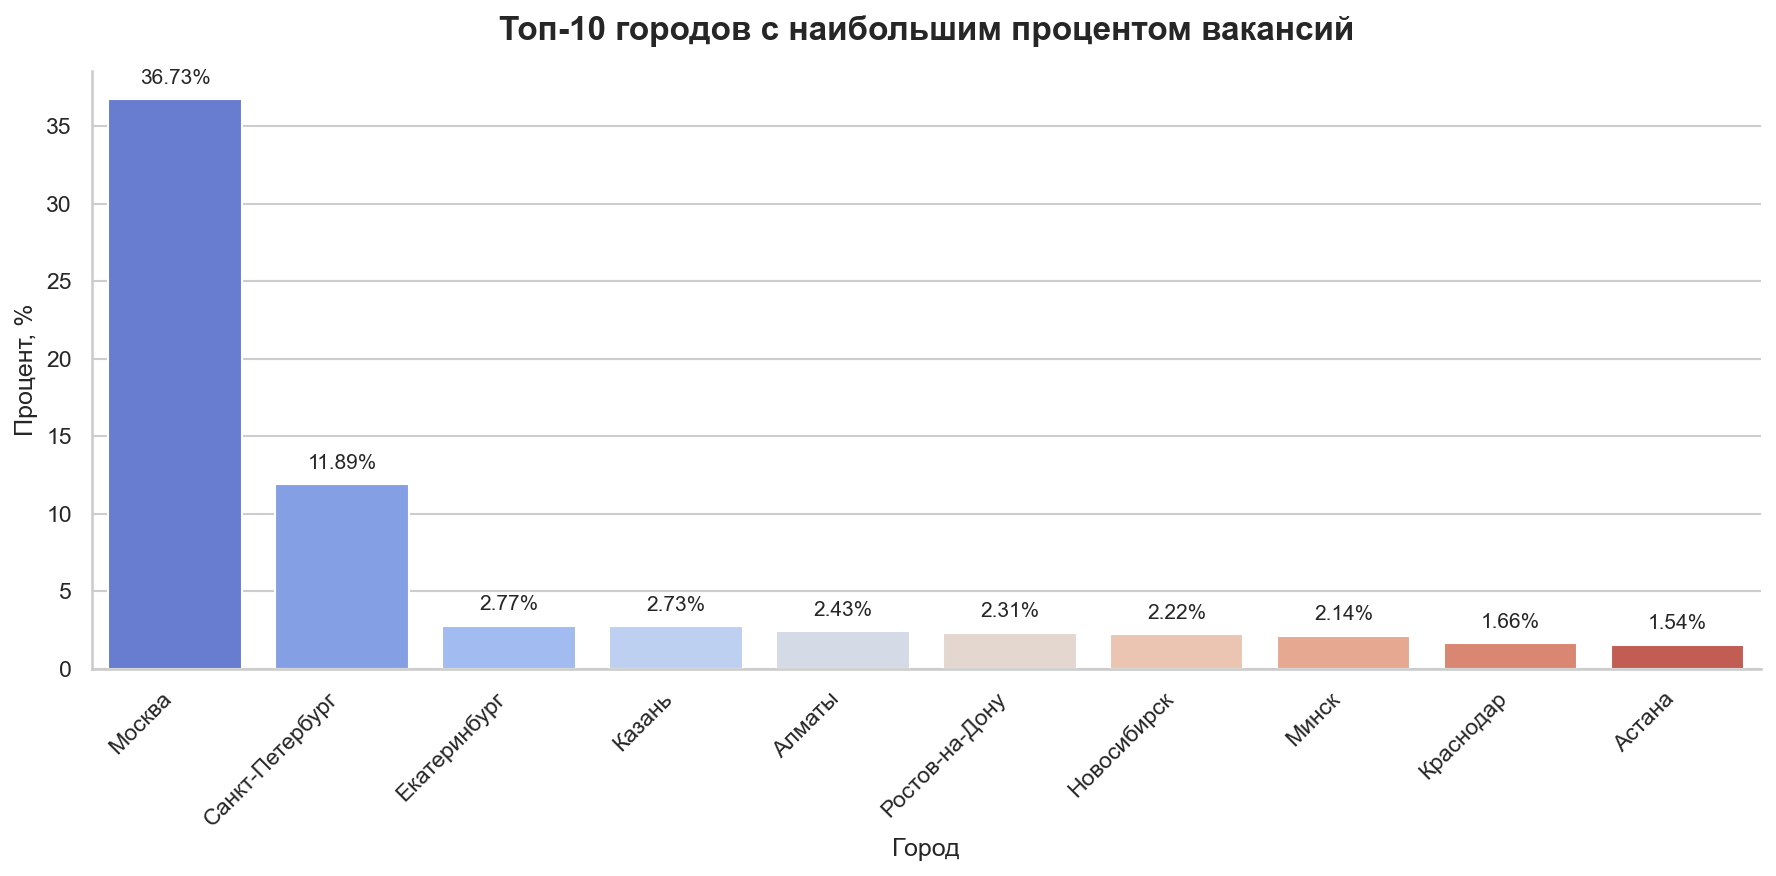

In [1195]:
plot_percent(analysis_df, 'area', 'Топ-10 городов с наибольшим процентом вакансий', 'Город');

График показывает распределение вакансий в сфере IT по городам. Москва значительно лидирует (36.73%), что намного больше, чем в любом другом городе. Санкт-Петербург занимает второе место с 11.89%, а остальные города показывают значительно меньший процент вакансий (от 2.77% до 1.54%).

Это можно объяснить тем, что Москва является крупнейшим экономическим и технологическим центром России, концентрирующим большую часть IT-компаний и специалистов, а также имеющим наибольшее количество крупных заказчиков IT-услуг. Санкт-Петербург, как второй по величине город, также имеет значительную IT-инфраструктуру, хотя и уступает Москве по масштабам. Остальные города в списке представляют региональные IT-рынки, значительно меньшие по объему.



## Расмотрим schedule

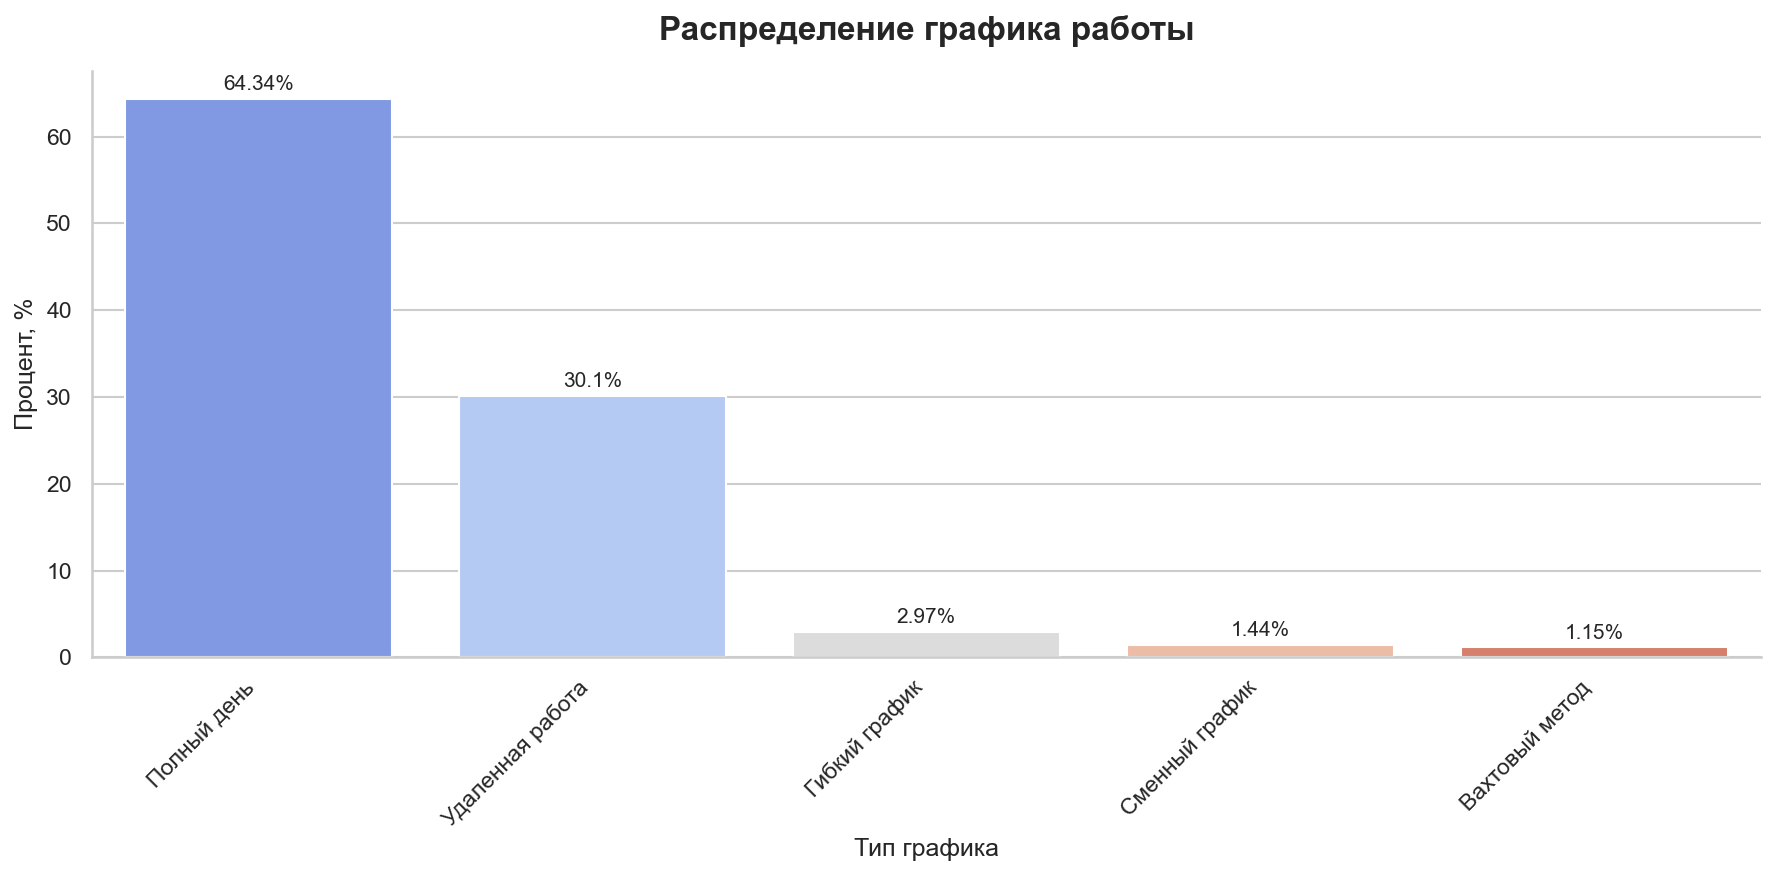

In [1196]:
plot_percent(analysis_df, 'schedule', 'Распределение графика работы', xlabel='Тип графика')

График иллюстрирует распределение вакансий в IT по типу графика работы. Преобладают вакансии с полным рабочим днем (64.34%) и удаленной работой (30.1%). Все остальные типы графиков (гибкий, сменный, вахтовый) представлены в значительно меньшем количестве (менее 3%).

Такое распределение можно объяснить несколькими факторами:

• Традиционные требования: Многие IT-компании, особенно крупные, традиционно работают по графику полного рабочего дня, что отражается в большом количестве соответствующих вакансий.

• Популярность удаленной работы: В IT-сфере удаленная работа стала очень распространенной, что подтверждается значительным процентом вакансий с этим типом графика. Это обусловлено возможностью гибкой организации рабочего процесса и доступностью специалистов из разных регионов.

• Низкая распространенность других графиков: Гибкий, сменный и вахтовый графики работы встречаются в IT реже, так как часто требуют специфической организации работы и могут быть неэффективными для многих IT-проектов, требующих координации и взаимодействия в режиме реального времени.

## Рассмотрим experience


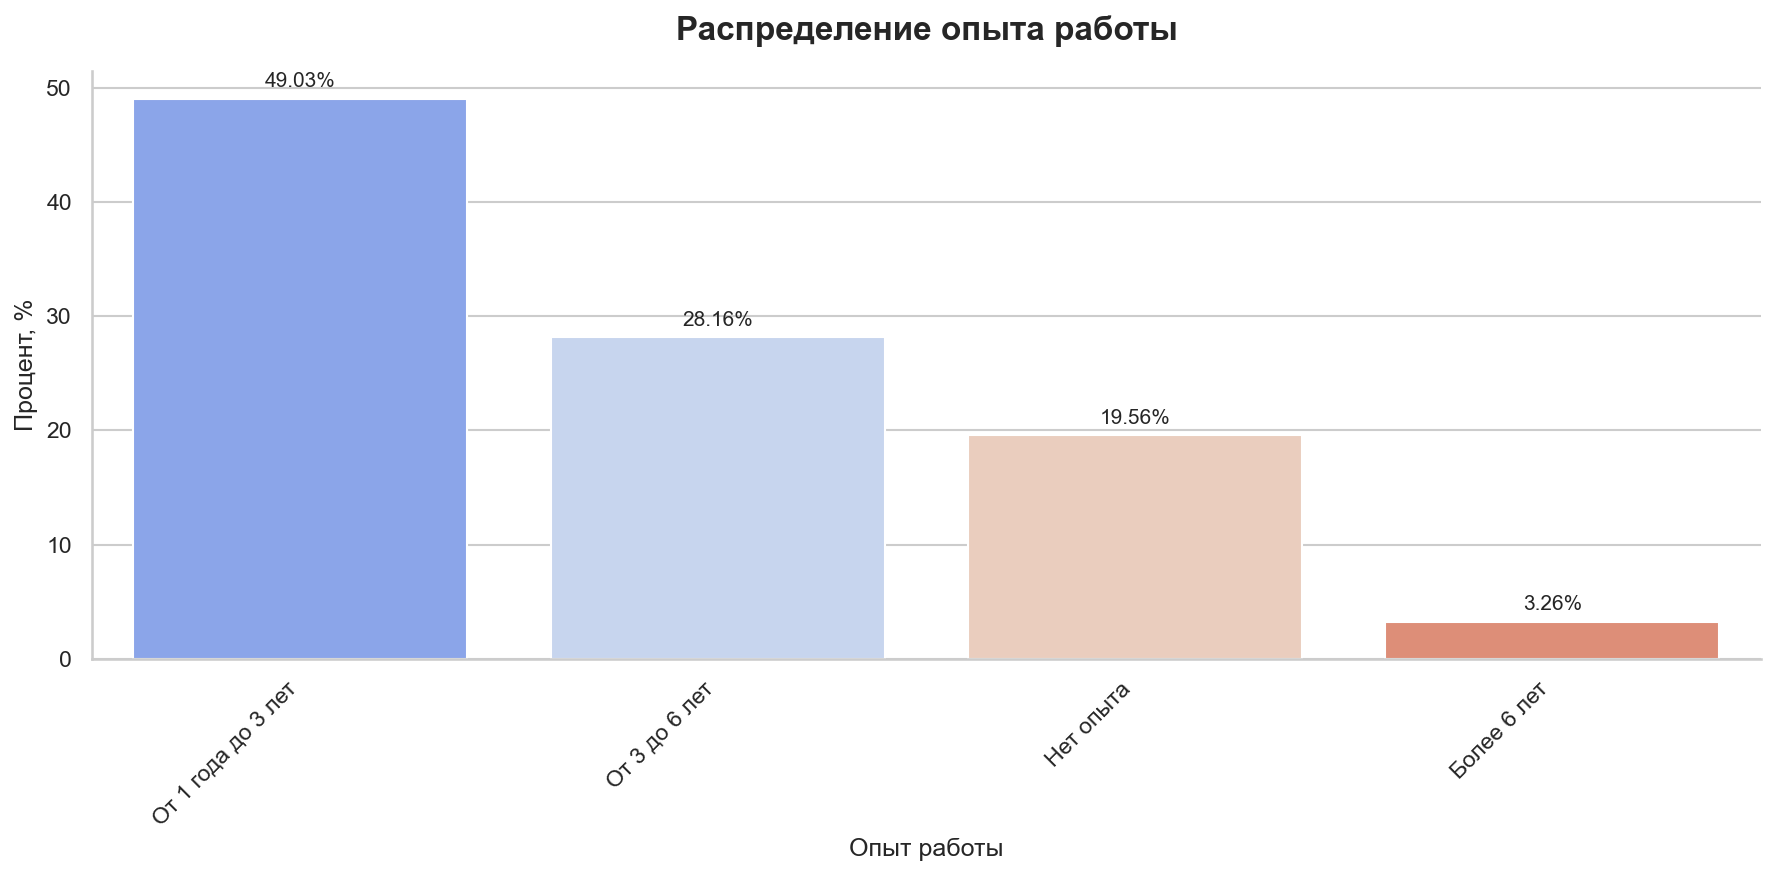

In [1197]:
plot_percent(analysis_df, 'experience', title='Распределение опыта работы', xlabel='Опыт работы')

График показывает распределение вакансий в IT по требуемому опыту работы. Наибольший процент (49.03%) приходится на вакансии, требующие от 1 до 3 лет опыта. Следующий по величине сегмент (28.16%) — вакансии, требующие от 3 до 6 лет опыта. Значительно меньше вакансий требуют отсутствия опыта (19.56%) или более 6 лет опыта (3.26%).

Это распределение отражает потребность IT-рынка в специалистах с определенным уровнем опыта. Большинство вакансий ориентированы на кандидатов со средним уровнем опыта (1-3 года), что логично, так как они уже обладают необходимыми знаниями и навыками, но при этом не требуют очень высокой заработной платы, характерной для senior-специалистов. Вакансии без опыта работы, вероятно, связаны с программами стажировок или junior-позициями, а вакансии, требующие более 6 лет опыта, — на senior или руководящие должности, которые встречаются реже.

## Рассмотрим employment

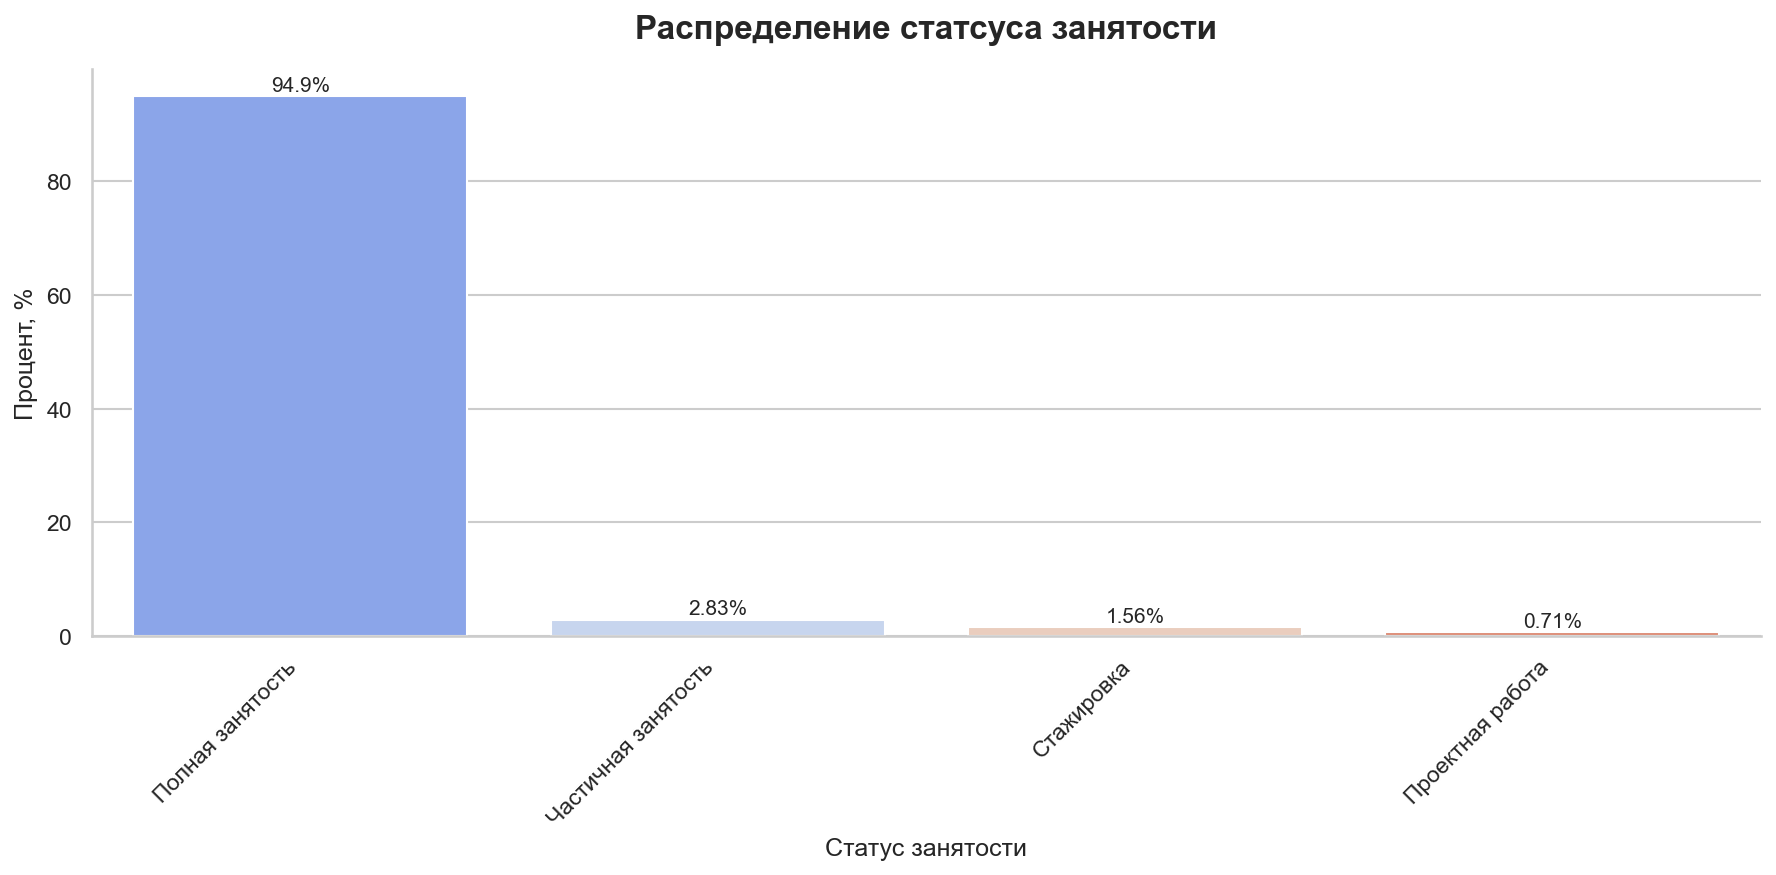

In [1198]:
plot_percent(analysis_df, 'employment', 'Распределение статсуса занятости', 'Cтатус занятости')

График демонстрирует распределение вакансий в IT по статусу занятости. Подавляющее большинство вакансий (94.9%) предполагают полную занятость. Доля вакансий с частичной занятостью составляет всего 2.83%, с предложениями о стажировке — 1.56%, а с проектной работой — 0.71%.

Это говорит о том, что рынок IT в основном ориентирован на кандидатов, готовых к полной занятости. Возможности для частичной занятости, стажировок и проектной работы представлены в очень ограниченном количестве, что может быть связано с особенностями организации работы в IT-сфере, где часто требуется высокая вовлеченность и постоянное взаимодействие в команде.


## Рассмотрим job

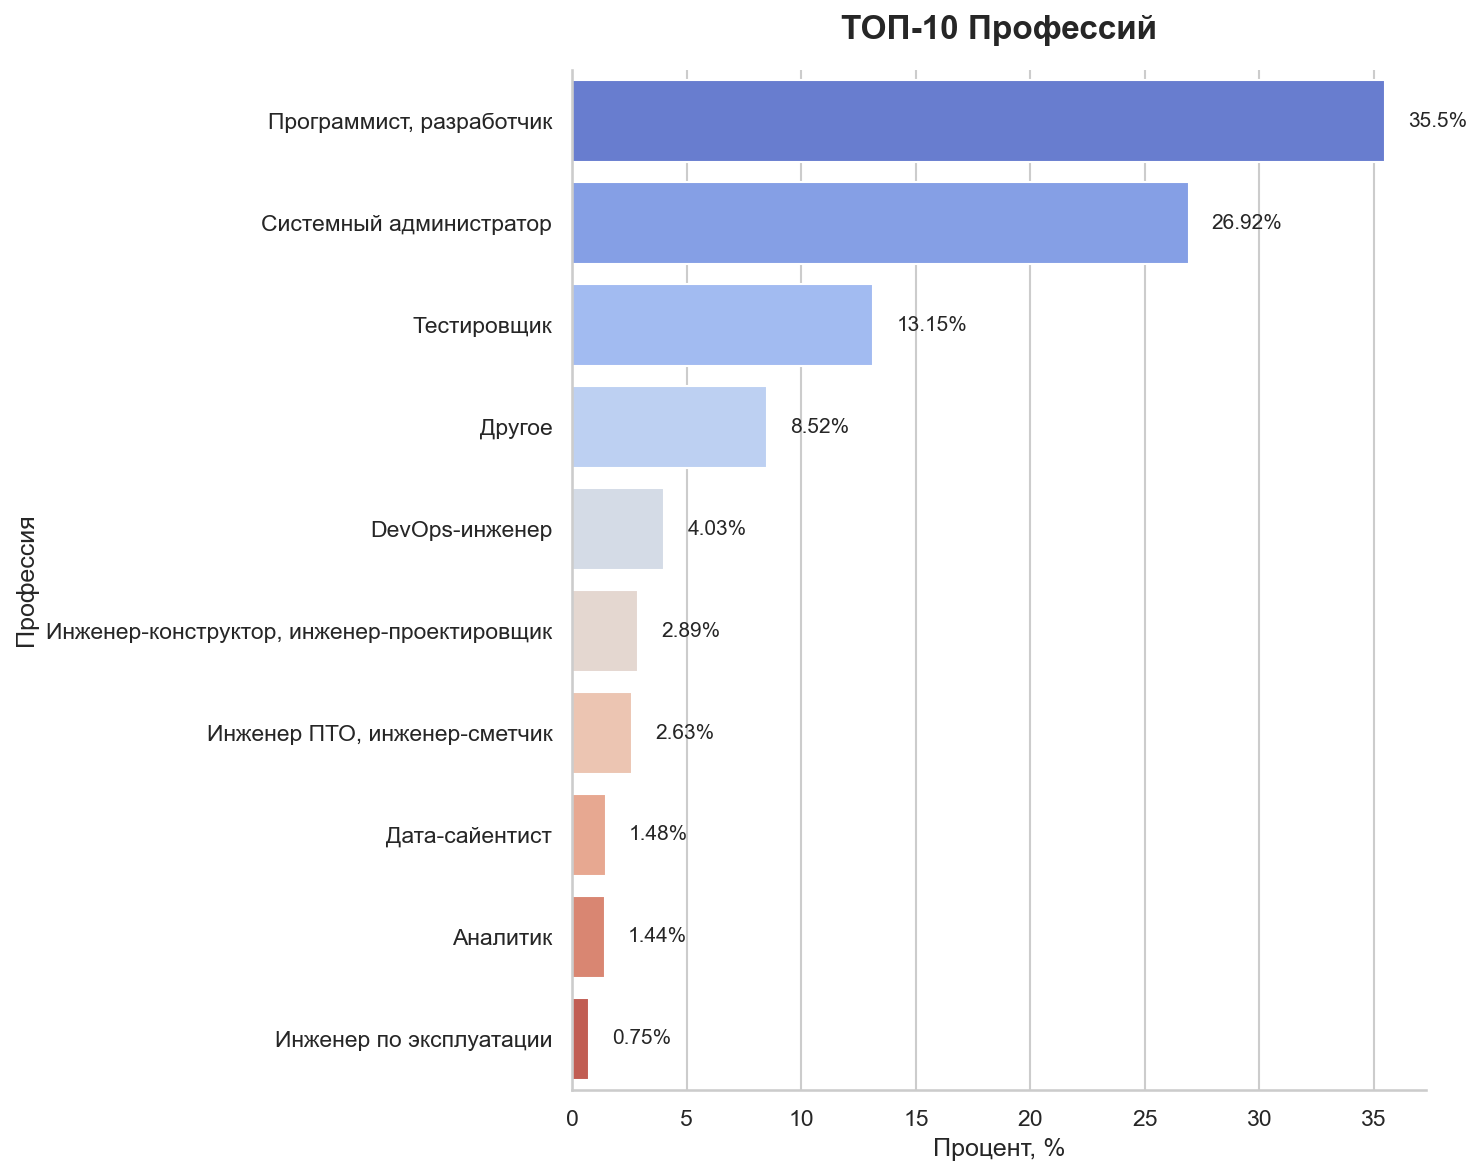

In [1199]:
plot_percent(analysis_df, 'job', 'ТОП-10 Профессий', 'Профессия', True)

График отображает топ-10 наиболее распространенных профессий в IT-вакансиях. Значительно лидируют программисты/разработчики (35.5%), за ними следуют системные администраторы (26.92%). Тестировщики составляют 13.15% от общего числа вакансий. Остальные профессии представлены в гораздо меньшем количестве (от 8.52% до 0.75%).

Это распределение отражает структуру спроса на IT-специалистов. Высокий спрос на программистов и системных администраторов обусловлен фундаментальной ролью этих специалистов в разработке и поддержке IT-систем. Тестировщики также востребованы из-за растущей важности контроля качества программного обеспечения. Остальные профессии представлены в меньшей степени, что может быть связано с более узкой специализацией или меньшим объемом вакансий на рынке.

## Расмотрим salary

In [1200]:
# Рассчитываем IQR (межквартильный размах)
Q1 = analysis_df['salary_rub'].quantile(0.25)  # первый квартиль
Q3 = analysis_df['salary_rub'].quantile(0.75)  # третий квартиль
IQR = Q3 - Q1  # межквартильный размах

# Границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем выбросы
filtered_data = analysis_df[(analysis_df['salary_rub'] >= lower_bound) & (analysis_df['salary_rub'] <= upper_bound)]

# Сравнение до и после
print(f"Размер данных до обработки: {analysis_df.shape[0]}")
print(f"Размер данных после обработки: {filtered_data.shape[0]}")

Размер данных до обработки: 4944
Размер данных после обработки: 4698


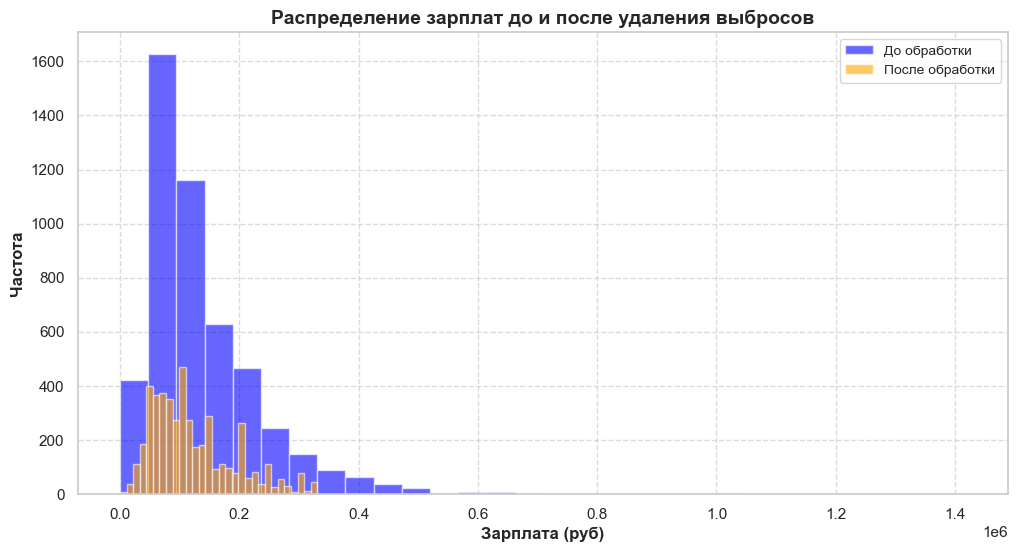

In [1201]:
plt.figure(figsize=(12, 6))  # Увеличим размер фигуры
plt.hist(analysis_df['salary_rub'], bins=30, alpha=0.6, color='blue', label='До обработки')  # Добавим цвет для до обработки
plt.hist(filtered_data['salary_rub'], bins=30, alpha=0.6, color='orange', label='После обработки')  # Добавим цвет для после обработки
plt.title('Распределение зарплат до и после удаления выбросов', fontsize=14, weight='bold')  # Увеличим шрифт заголовка
plt.xlabel('Зарплата (руб)', fontsize=12, weight='bold')  # Увеличим шрифт осей
plt.ylabel('Частота', fontsize=12, weight='bold')
plt.legend(loc='upper right', fontsize=10)  # Позиция легенды и размер шрифта
plt.grid(True, linestyle='--', alpha=0.7)  # Добавим сетку с изменёнными параметрами
plt.show()

Гистограмма показывает распределение зарплат в IT-сфере до и после удаления выбросов. До обработки данных (голубой цвет) распределение имеет длинный правый хвост, указывающий на наличие высоких значений зарплат (выбросов). После обработки данных (оранжевый цвет) распределение становится более сконцентрированным и симметричным, правый хвост укоротился, что говорит об успешном удалении выбросов. Большая часть зарплат сосредоточена в диапазоне от 0 до 200 000 рублей.

Это типичный пример работы с выбросами в данных. Выбросы (вероятно, очень высокие зарплаты топ-менеджеров или специалистов с уникальными навыками) искажают истинное распределение зарплат. Их удаление позволяет получить более точную и репрезентативную картину средних зарплат в IT-сфере.

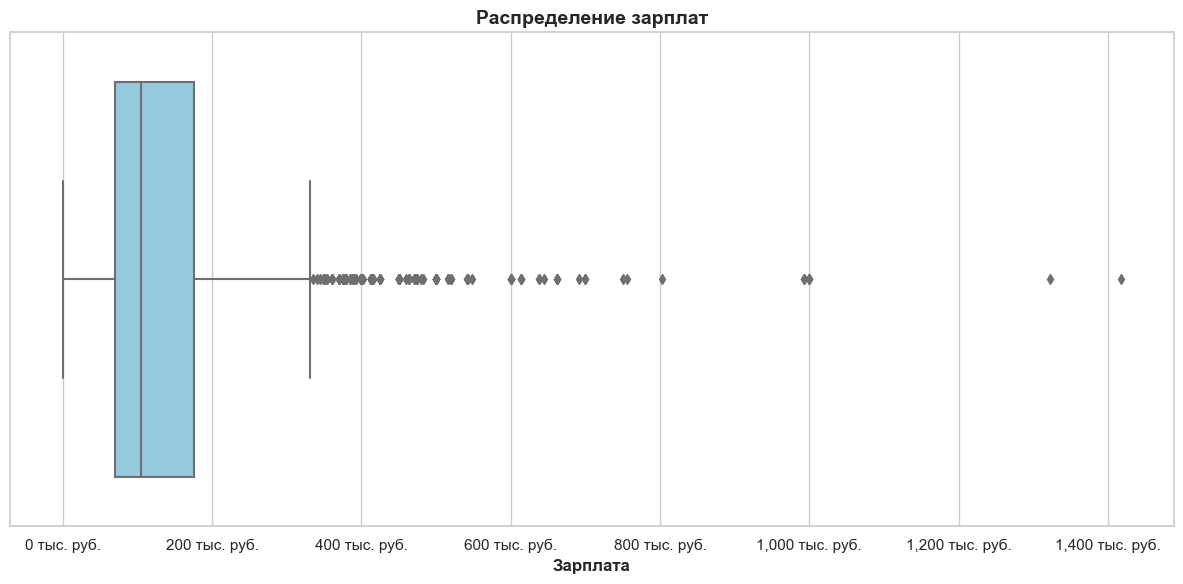

In [1202]:
# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Построение графика
plt.figure(figsize=(12, 6))  # Увеличим размер фигуры
sns.boxplot(x=analysis_df['salary_rub'], color='skyblue')  # Добавим светлый цвет для бокса

# Форматирование оси X
formatter = FuncFormatter(lambda x, pos: f'{int(x / 1000):,} тыс. руб.')
plt.gca().xaxis.set_major_formatter(formatter)

# Настроим подписи осей и заголовок
plt.xlabel('Зарплата', fontsize=12, weight='bold')
plt.title('Распределение зарплат', fontsize=14, weight='bold')

# Упорядочим макет и отобразим график
plt.tight_layout()
plt.show()

Ящик с усами (boxplot) демонстрирует распределение зарплат. Большинство зарплат (основная масса данных) сосредоточено в диапазоне примерно от 0 до 200 тысяч рублей (это видно по размеру ящика). Однако присутствуют значительные выбросы (отмечены точками), которые значительно выше медианы и указывают на наличие очень высоких зарплат. Медиана (средняя линия в ящике) находится примерно в районе 150 000 рублей.

Этот график ясно показывает, что распределение зарплат в IT-сфере асимметрично и содержит выбросы, которые искажают общее представление о типичной зарплате. Необходимо осторожно интерпретировать среднее значение, так как оно будет сильно смещено выбросами в сторону больших значений. Медиана является более надежной характеристикой центральной тенденции в этом случае.

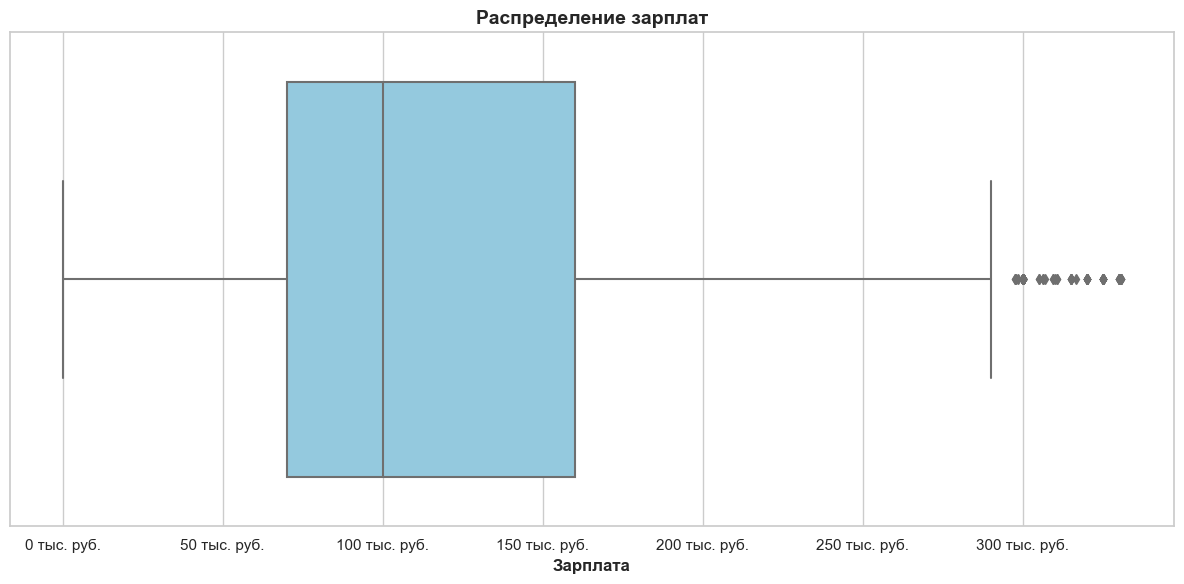

In [1203]:
# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Построение графика
plt.figure(figsize=(12, 6))  # Увеличим размер фигуры
sns.boxplot(x=filtered_data['salary_rub'], color='skyblue')  # Добавим светлый цвет для бокса

# Форматирование оси X
formatter = FuncFormatter(lambda x, pos: f'{int(x / 1000):,} тыс. руб.')
plt.gca().xaxis.set_major_formatter(formatter)

# Настроим подписи осей и заголовок
plt.xlabel('Зарплата', fontsize=12, weight='bold')
plt.title('Распределение зарплат', fontsize=14, weight='bold')

# Упорядочим макет и отобразим график
plt.tight_layout()
plt.show()

Этот ящик с усами (boxplot) показывает распределение зарплат после удаления выбросов, по сравнению с предыдущим графиком. Теперь основная масса данных сосредоточена в гораздо более узком диапазоне — приблизительно от 80 000 до 160 000 рублей. Количество выбросов значительно сократилось. Медиана зарплаты находится примерно посередине ящика.

По сравнению с предыдущим графиком, видно, что предварительная обработка данных (удаление выбросов) существенно изменила вид распределения. Распределение стало более компактным и симметричным, что обеспечивает более точное представление о типичной зарплате в IT-сфере, исключая влияние аномально высоких значений. Теперь медиана является более точной оценкой центральной тенденции распределения зарплат.

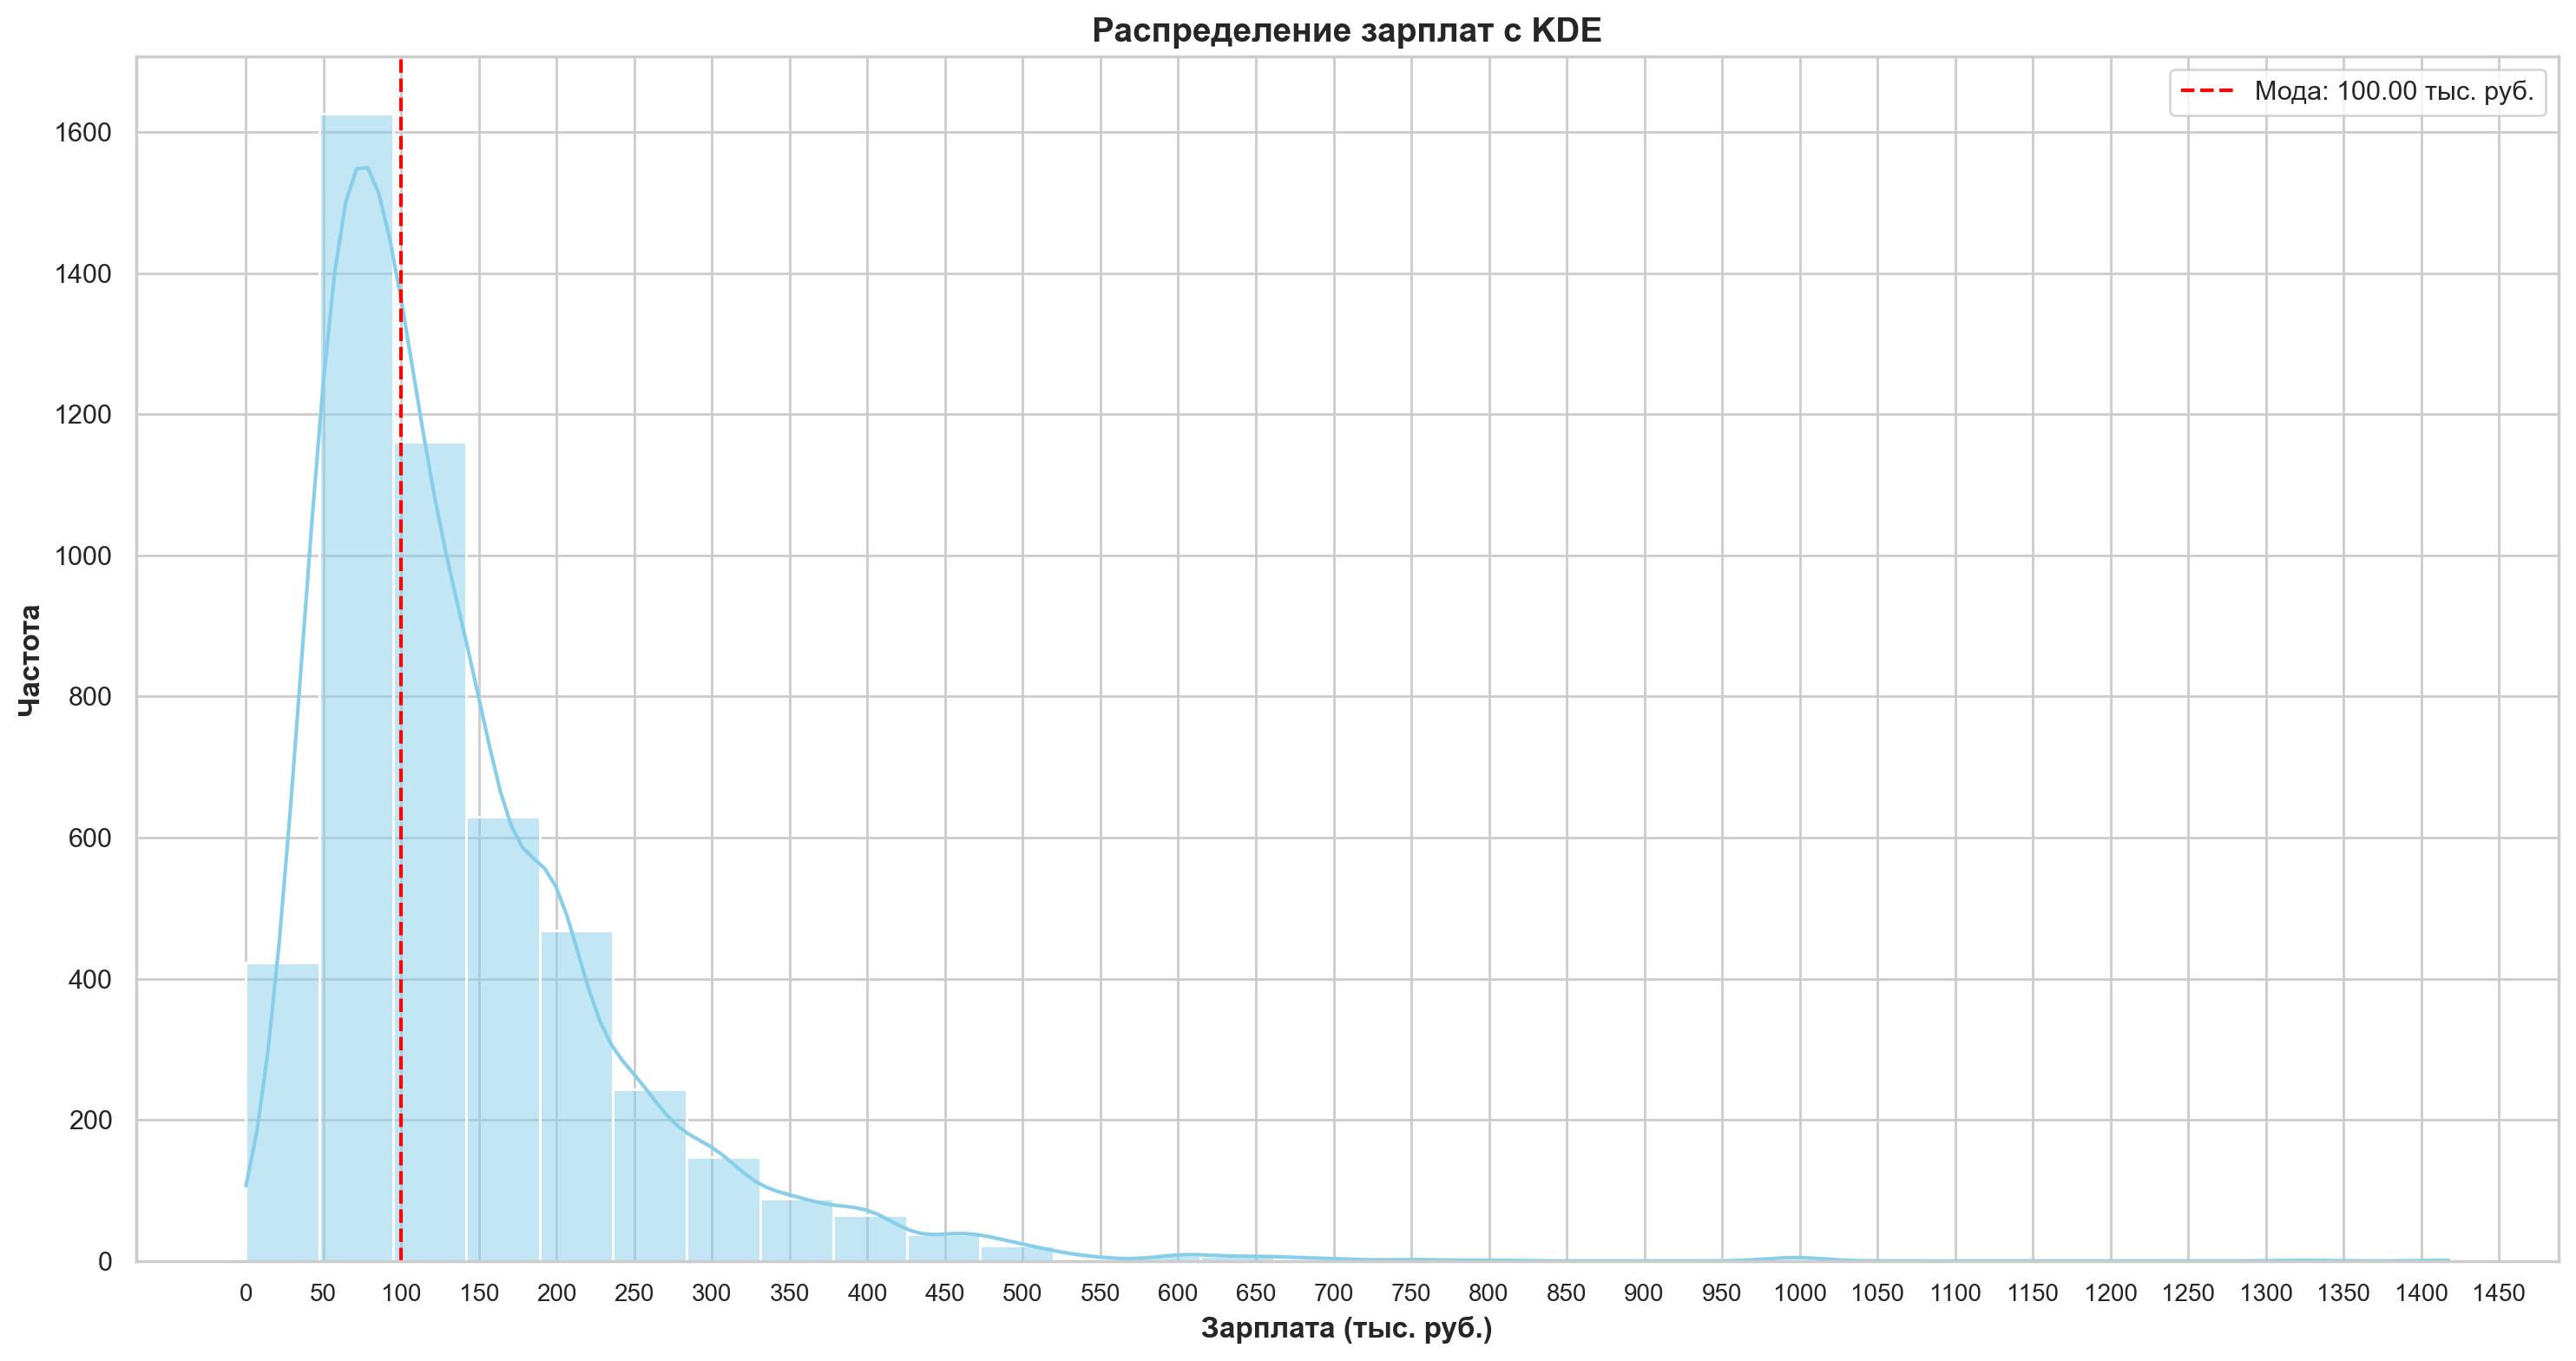

In [1204]:
# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Построение графика
plt.figure(figsize=(15, 8), dpi=200)  # Увеличим размер фигуры и разрешение

# Вычисляем моду
mode_salary = analysis_df['salary_rub'].mode()[0]

# Построение histplot с KDE для распределения зарплат
sns.histplot(analysis_df['salary_rub'], kde=True, color='skyblue', bins=30)

# Изменяем ось X, чтобы отображать значения в тысячах
plt.xlabel('Зарплата (тыс. руб.)', fontsize=12, weight='bold')
plt.ylabel('Частота', fontsize=12, weight='bold')
plt.title('Распределение зарплат с KDE', fontsize=14, weight='bold')

# Добавляем линию моды на график
plt.axvline(mode_salary, color='red', linestyle='--', label=f'Мода: {mode_salary / 1000:.2f} тыс. руб.')

# Показываем легенду
plt.legend()

# Настроим ось X, шаг 50 тыс.
xticks = np.arange(0, analysis_df['salary_rub'].max() + 50000, step=50000)  # Шаг 50 тыс.
plt.xticks(xticks, labels=[f'{int(x/1000)}' for x in xticks], fontsize=10)  # Без "тыс. руб." в метках

plt.tight_layout()
plt.show()

Гистограмма с кривой плотности (KDE) показывает распределение зарплат с учетом выбросов. Распределение правосторонне асимметрично, с длинным правым хвостом, что свидетельствует о наличии высоких зарплат (выбросов). Мода (наиболее часто встречающееся значение) находится примерно на уровне 100 000 рублей, что отображено на графике вертикальной пунктирной линией. Большинство зарплат сосредоточены в диапазоне до 250 000 рублей.

Наличие длинного хвоста указывает на то, что в выборке присутствуют значительно большие зарплаты, чем у большинства. Это может быть связано с наличием высокооплачиваемых позиций или случайными ошибками в данных. Для более точного анализа распределения желательно провести обработку данных, например, удалить выбросы или применить логарифмическое преобразование. В текущем виде среднее значение зарплаты будет завышено из-за влияния выбросов, и мода является более репрезентативной характеристикой центральной тенденции.

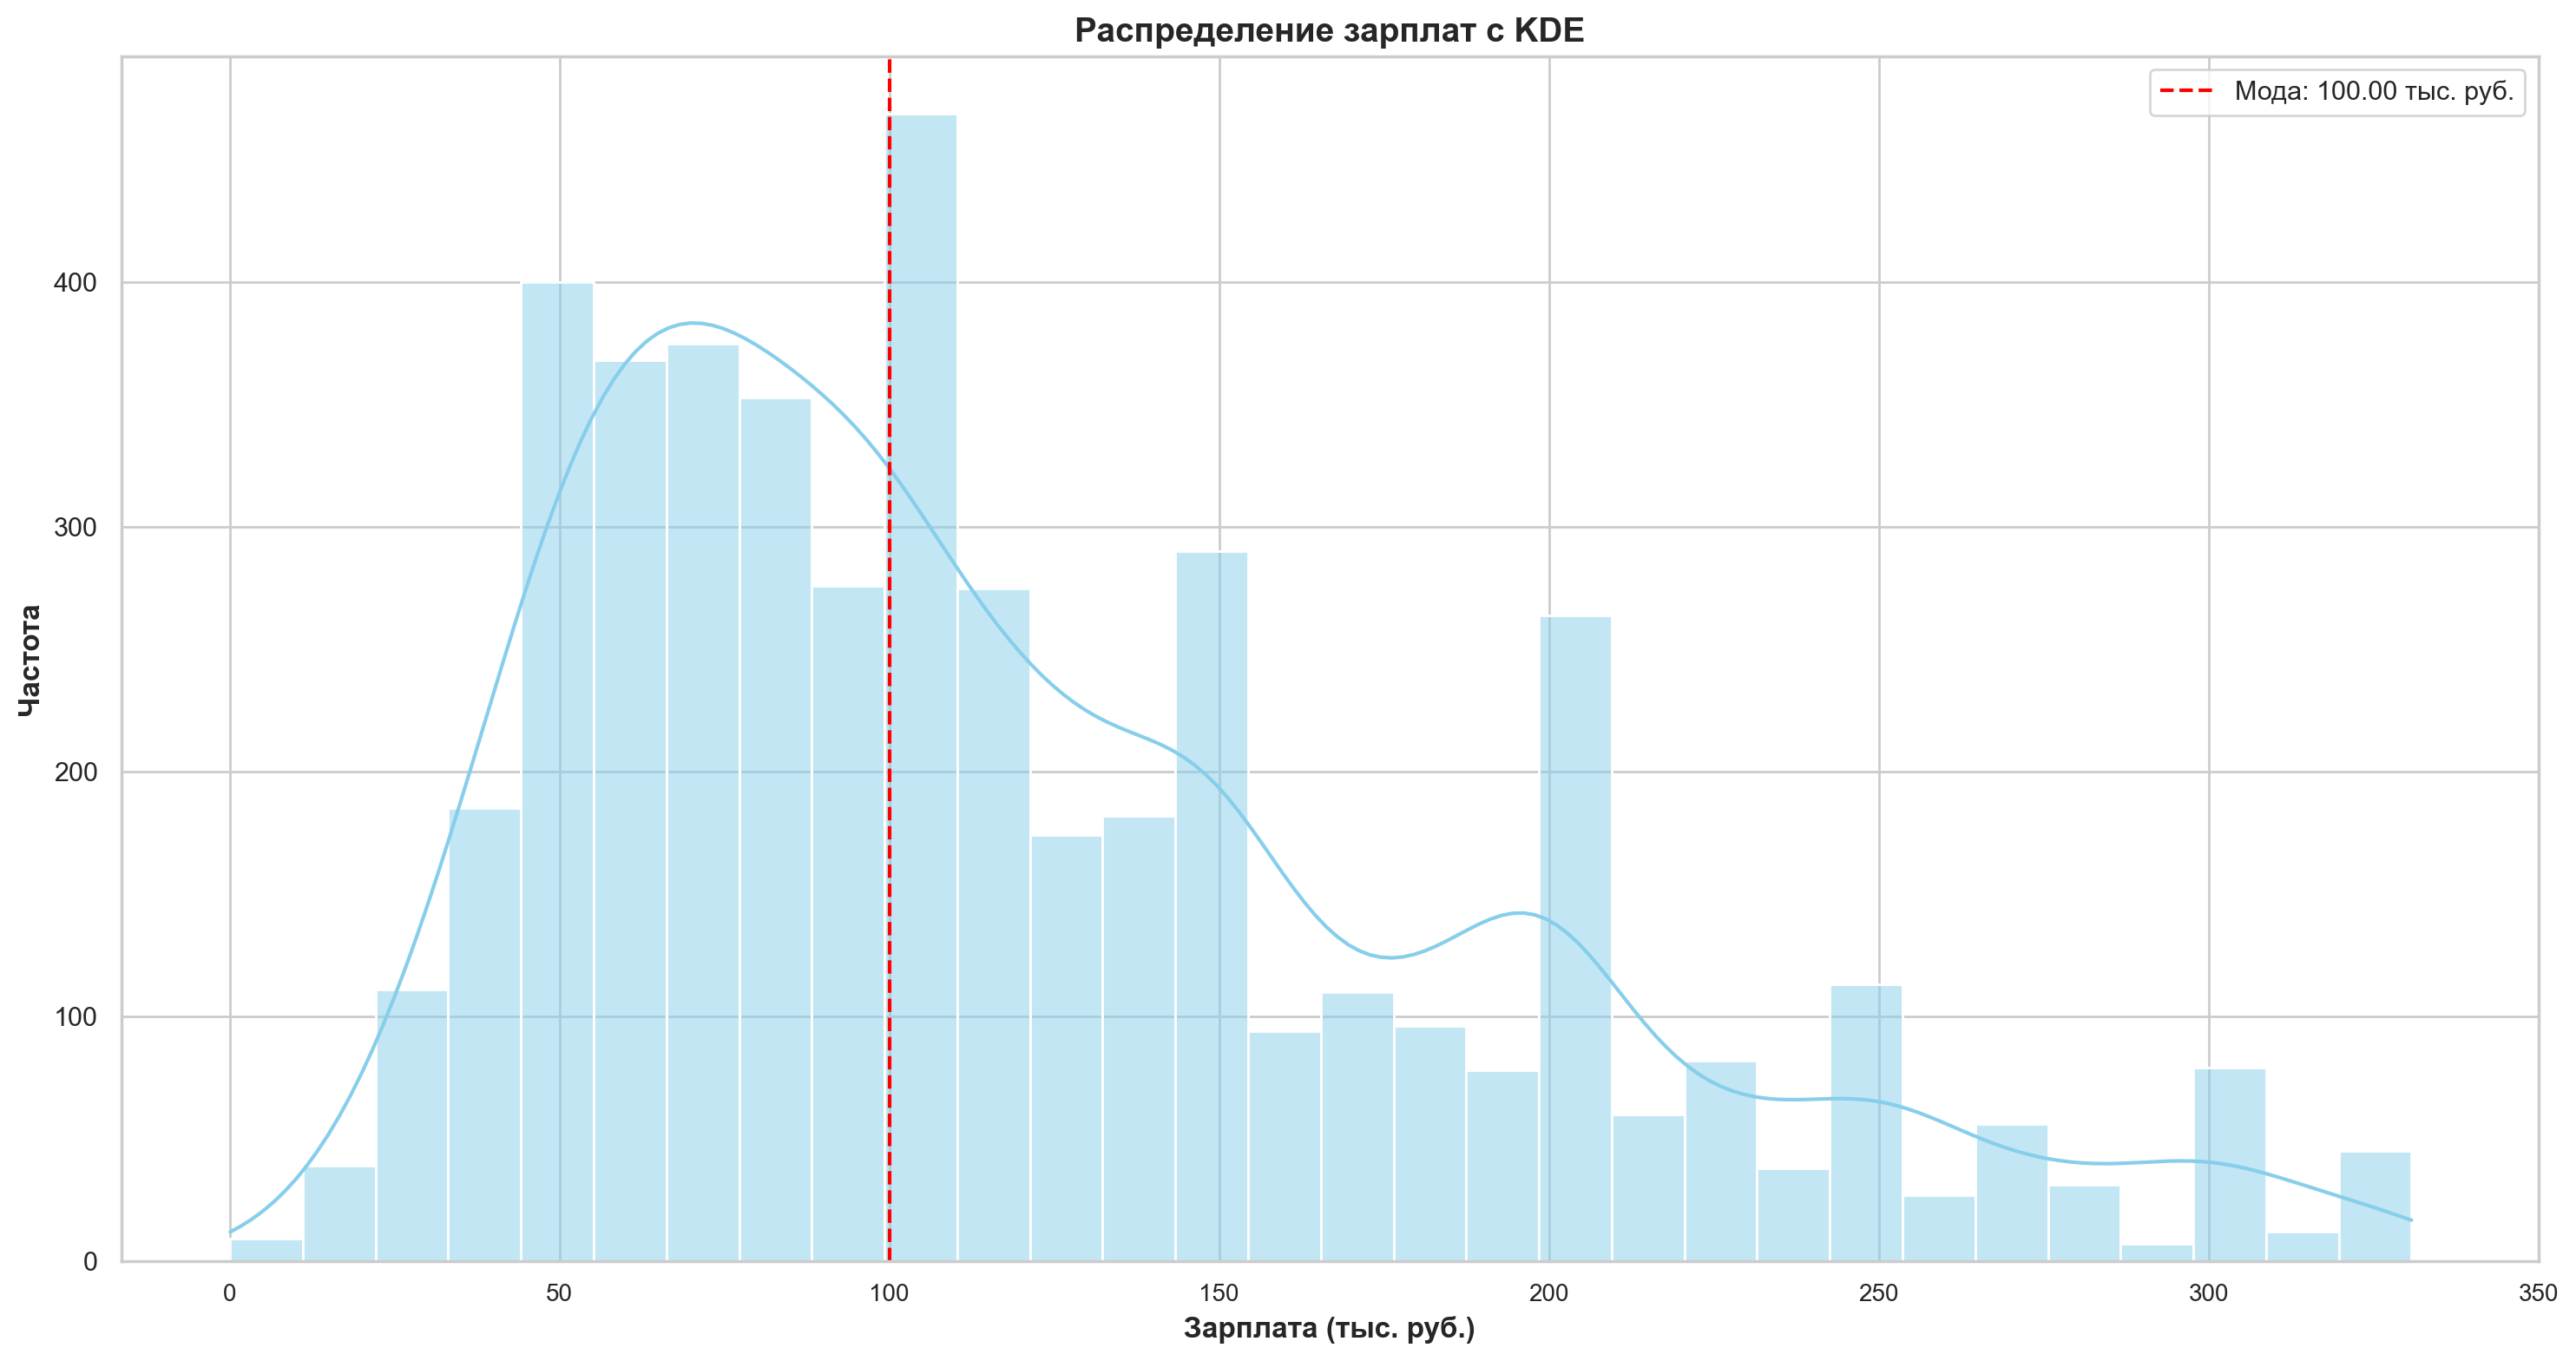

In [1205]:
# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Построение графика
plt.figure(figsize=(15, 8), dpi=200)  # Увеличим размер фигуры и разрешение

# Вычисляем моду
mode_salary = filtered_data['salary_rub'].mode()[0]

# Построение histplot с KDE для распределения зарплат
sns.histplot(filtered_data['salary_rub'], kde=True, color='skyblue', bins=30)

# Изменяем ось X, чтобы отображать значения в тысячах
plt.xlabel('Зарплата (тыс. руб.)', fontsize=12, weight='bold')
plt.ylabel('Частота', fontsize=12, weight='bold')
plt.title('Распределение зарплат с KDE', fontsize=14, weight='bold')

# Добавляем линию моды на график
plt.axvline(mode_salary, color='red', linestyle='--', label=f'Мода: {mode_salary / 1000:.2f} тыс. руб.')

# Показываем легенду
plt.legend()

# Настроим ось X, шаг 50 тыс.
xticks = np.arange(0, filtered_data['salary_rub'].max() + 50000, step=50000)  # Шаг 50 тыс.
plt.xticks(xticks, labels=[f'{int(x/1000)}' for x in xticks], fontsize=10)  # Без "тыс. руб." в метках

plt.tight_layout()
plt.show()

Гистограмма с кривой плотности (KDE) показывает распределение зарплат после удаления выбросов. В отличие от предыдущего графика, распределение стало более симметричным и менее "растянутым". Мода (вертикальная пунктирная линия) по-прежнему находится примерно на уровне 100 000 рублей. Большая часть зарплат сосредоточена в диапазоне от 50 000 до 200 000 рублей. Длинного правого хвоста, характерного для выбросов, уже нет.

Удаление выбросов позволило получить более точное представление о типичном уровне зарплат в IT-сфере. Теперь распределение выглядит более реалистичным и позволяет делать более обоснованные выводы о центральной тенденции и дисперсии зарплат. Мода и медиана, вероятно, теперь будут более близкими друг к другу, а среднее значение будет более релевантным показателем.

# Гипотезы

## Гипотеза: Заработная плата зависит от региона.

### Зарплата в городе Минск неверно отображается - исправим 


In [1206]:
# Преобразуем зарплату внутри DataFrame для региона 'Минск', если зарплата меньше 1000
analysis_df.loc[(analysis_df['area'] == 'Минск') & (analysis_df['salary_rub'] < 1000), 'salary_rub'] *= 1000

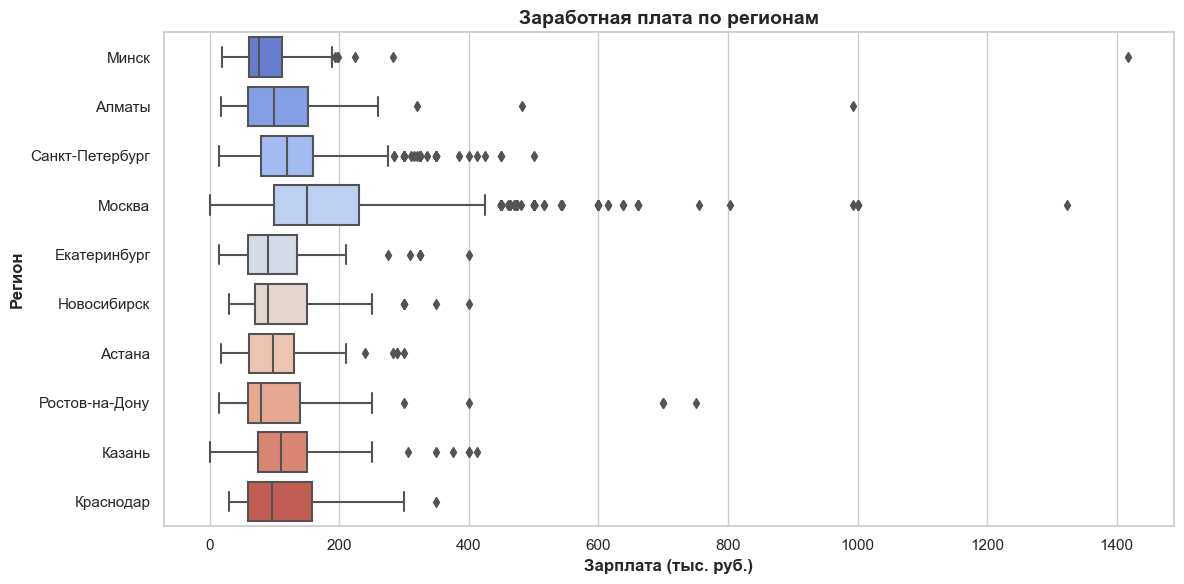

In [1207]:
# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Сформируем топ-10 регионов
top_10_area = analysis_df[analysis_df['area'].isin(['Москва', 'Санкт-Петербург', 'Екатеринбург', 'Казань', 'Алматы', 
                                                     'Ростов-на-Дону', 'Новосибирск', 'Минск', 'Краснодар', 'Астана'])]

# Используем .loc для изменения значения в столбце
top_10_area.loc[:, 'salary_rub'] = top_10_area['salary_rub'] / 1000  # Преобразуем зарплату в тысячи

# Построение графика
plt.figure(figsize=(12, 6))  # Увеличим размер фигуры
sns.boxplot(data=top_10_area, y='area', x='salary_rub', palette='coolwarm')  # Добавим палитру цвета для улучшения визуализации

# Настроим подписки осей и заголовок
plt.ylabel('Регион', fontsize=12, weight='bold')
plt.xlabel('Зарплата (тыс. руб.)', fontsize=12, weight='bold')
plt.title('Заработная плата по регионам', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

Ящик с усами (boxplot) отображает распределение зарплат по регионам с учетом выбросов. Видно, что Москва имеет наибольший разброс зарплат с наличием высоких выбросов. Санкт-Петербург также показывает значительное количество выбросов. Остальные регионы имеют меньший разброс зарплат, и выбросы встречаются реже. Медиана зарплаты, как правило, ниже, чем у Москвы и Санкт-Петербурга.

Наличие выбросов указывает на то, что в некоторых регионах есть позиции с очень высокими зарплатами, которые значительно отличаются от типичных значений. Это может быть связано с разными факторами, такими как специфика отрасли, наличие крупных компаний, конкуренция на рынке труда и т.д. Для более точного анализа необходимо обработать данные и удалить выбросы, чтобы получить более ясную картину распределения зарплат по регионам. В текущем виде выводы о средних зарплатах по регионам будут неточными из-за влияния выбросов.

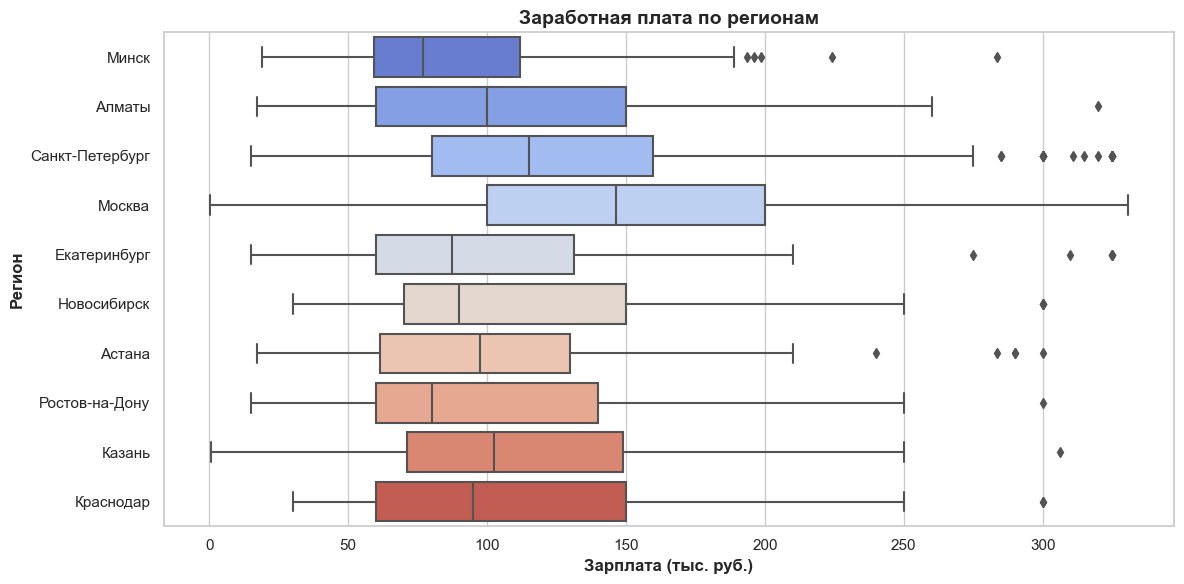

In [1208]:
# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Сформируем топ-10 регионов
top_10_area = filtered_data[filtered_data['area'].isin(['Москва', 'Санкт-Петербург', 'Екатеринбург', 'Казань', 'Алматы', 
                                                     'Ростов-на-Дону', 'Новосибирск', 'Минск', 'Краснодар', 'Астана'])]

# Используем .loc для изменения значения в столбце
top_10_area.loc[:, 'salary_rub'] = top_10_area['salary_rub'] / 1000  # Преобразуем зарплату в тысячи

# Построение графика
plt.figure(figsize=(12, 6))  # Увеличим размер фигуры
sns.boxplot(data=top_10_area, y='area', x='salary_rub', palette='coolwarm')  # Добавим палитру цвета для улучшения визуализации

# Настроим подписки осей и заголовок
plt.ylabel('Регион', fontsize=12, weight='bold')
plt.xlabel('Зарплата (тыс. руб.)', fontsize=12, weight='bold')
plt.title('Заработная плата по регионам', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

Этот ящик с усами (boxplot) показывает распределение зарплат по регионам после удаления выбросов. По сравнению с предыдущим графиком, разброс зарплат в каждом регионе уменьшился, и количество выбросов значительно сократилось. Москва по-прежнему показывает наиболее высокую медиану зарплаты, но разброс стал меньше.

Удаление выбросов позволило получить более точное и репрезентативное представление о типичных уровнях зарплат в разных регионах. Теперь можно с большей уверенностью сравнивать медианы и интерквартильные размахи зарплат в разных городах, не учитывая влияние аномально высоких значений. Москва, как и ожидалось, остаётся лидером по уровню зарплат, но различия между регионами стали более явными и менее искажёнными.

## Гипотеза: Чем больше опыта, тем выше заработная плата.

In [1209]:
experience_salary = analysis_df.groupby('experience')['salary_rub'].mean().round().reset_index(name='mean_salary').sort_values(by='mean_salary')
experience_salary

,experience,mean_salary
1,Нет опыта,71223.0
2,От 1 года до 3 лет,113788.0
3,От 3 до 6 лет,207717.0
0,Более 6 лет,285106.0


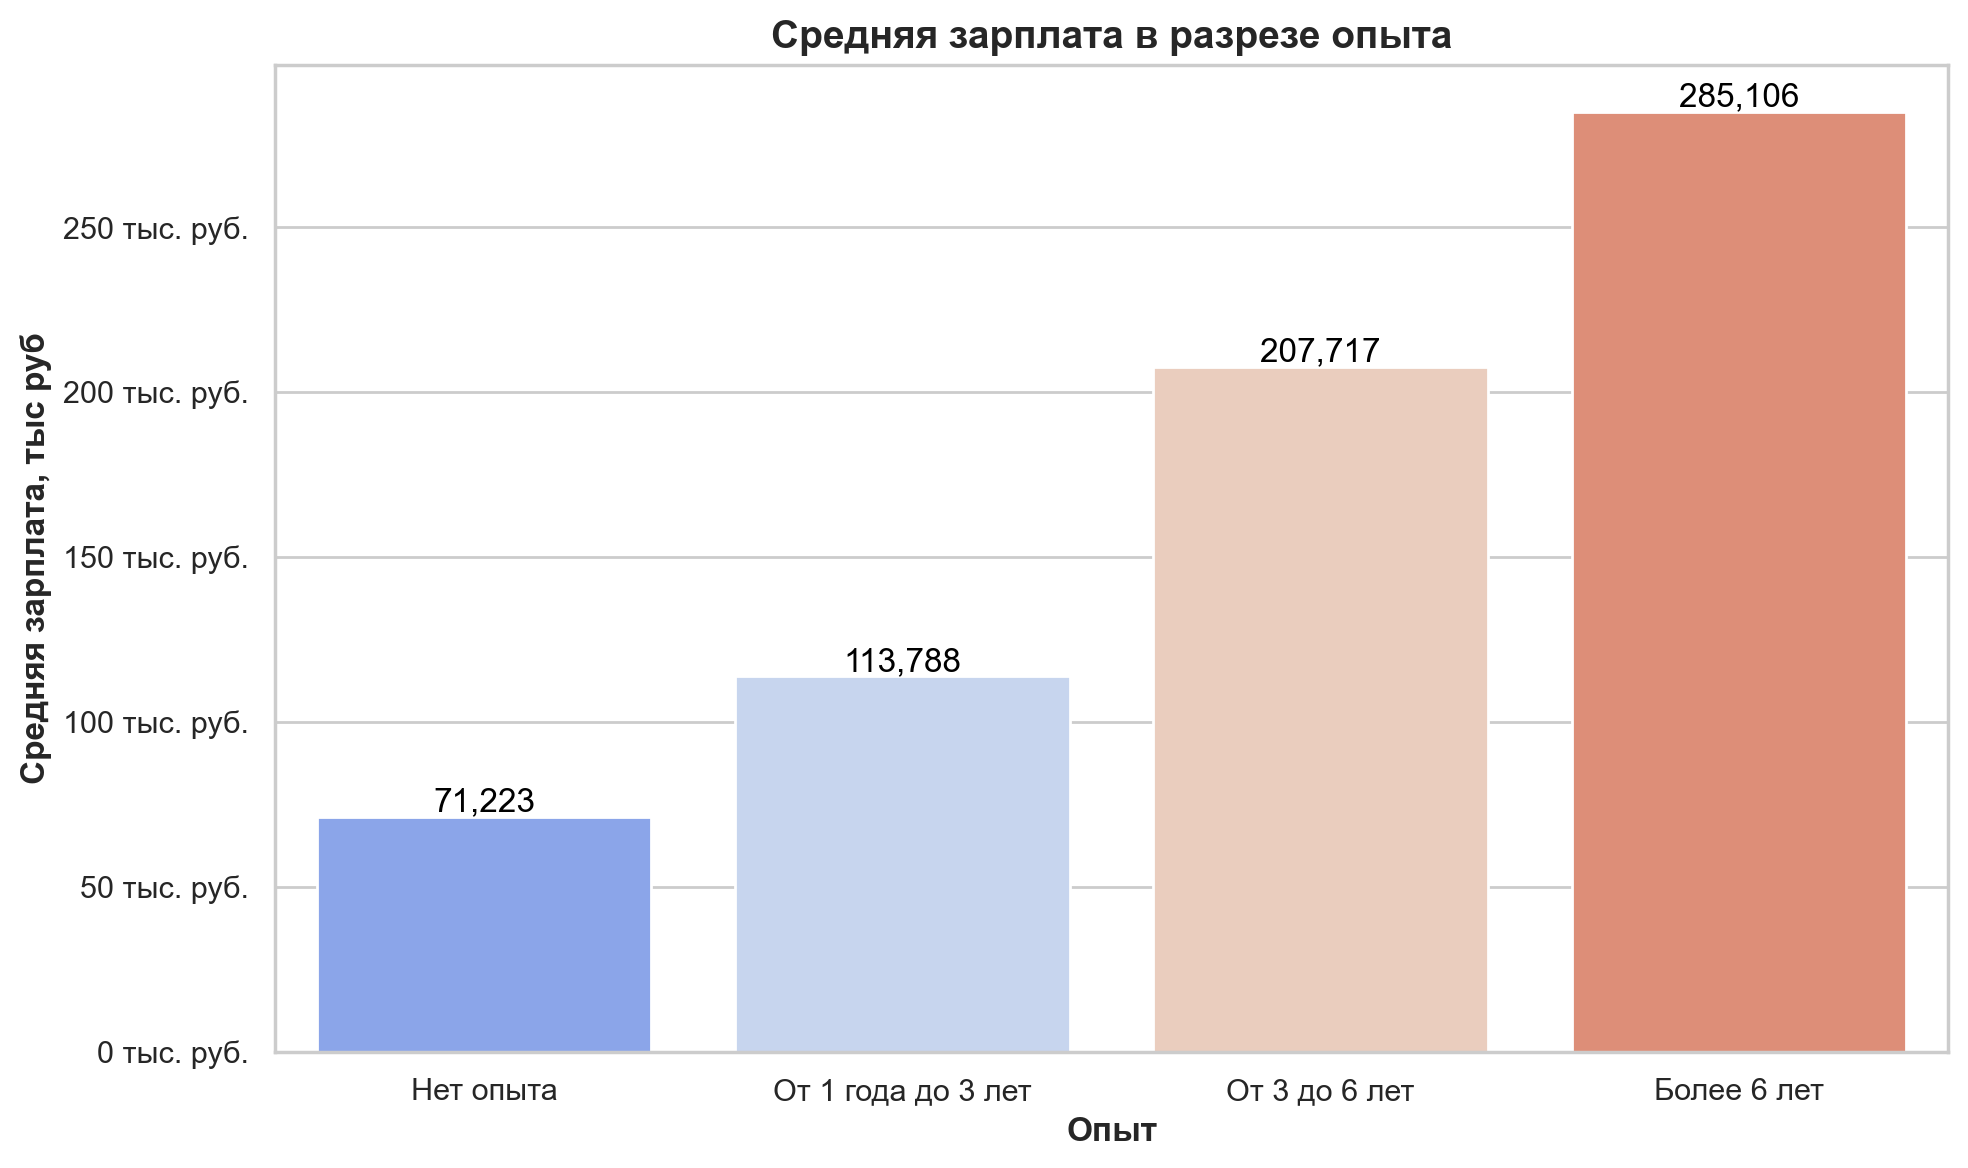

In [1210]:
# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Построение графика
plt.figure(figsize=(10, 6), dpi=200)  # Увеличим размер фигуры и разрешение
ax = sns.barplot(data=experience_salary, x='experience', y='mean_salary', palette='coolwarm')  # Добавим пастельные оттенки для столбцов

# Добавление значений над столбцами
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Форматирование оси Y
formatter = FuncFormatter(lambda x, pos: f'{int(x / 1000):,} тыс. руб.')
ax.yaxis.set_major_formatter(formatter)

# Подписи и заголовок
plt.xlabel('Опыт', fontsize=12, weight='bold')
plt.ylabel('Средняя зарплата, тыс руб', fontsize=12, weight='bold')
plt.title('Средняя зарплата в разрезе опыта', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

Столбчатая диаграмма демонстрирует среднюю зарплату в зависимости от опыта работы. Наблюдается явная положительная корреляция: с увеличением опыта зарплата растёт. Рассмотрим количественные изменения:
* Отсутсвие опыта: 71,223 руб.

* От 1 до 3 лет: 113,788 руб. Увеличение на 60% по сравнению с отсутствием опыта.

* От 3 до 6 лет: 207,717 руб. Увеличение на 83% по сравнению с опытом от 1 до 3 лет, и на 192% по сравнению с отсутствием опыта.

* Более 6 лет: 285,106 руб. Увеличение на 37% по сравнению с опытом от 3 до 6 лет, на 100% по сравнению с опытом от 1 до 3 лет, и на 300% по сравнению с отсутствием опыта.

Вывод: Гипотеза о том, что чем больше опыта, тем выше заработная плата, полностью подтверждается. График демонстрирует существенное и последовательное увеличение средней заработной платы с ростом опыта работы. Прирост зарплаты значителен на каждом этапе накопления опыта.





## Гипотеза: Полная занятость дает более высокую зарплату по сравнению со стажировками.

In [1211]:
employment_salary =analysis_df.groupby('employment')['salary_rub'].mean().round().reset_index(name='mean_salary').sort_values(by='mean_salary')
employment_salary

,employment,mean_salary
2,Стажировка,59641.0
3,Частичная занятость,79592.0
0,Полная занятость,140390.0
1,Проектная работа,151180.0


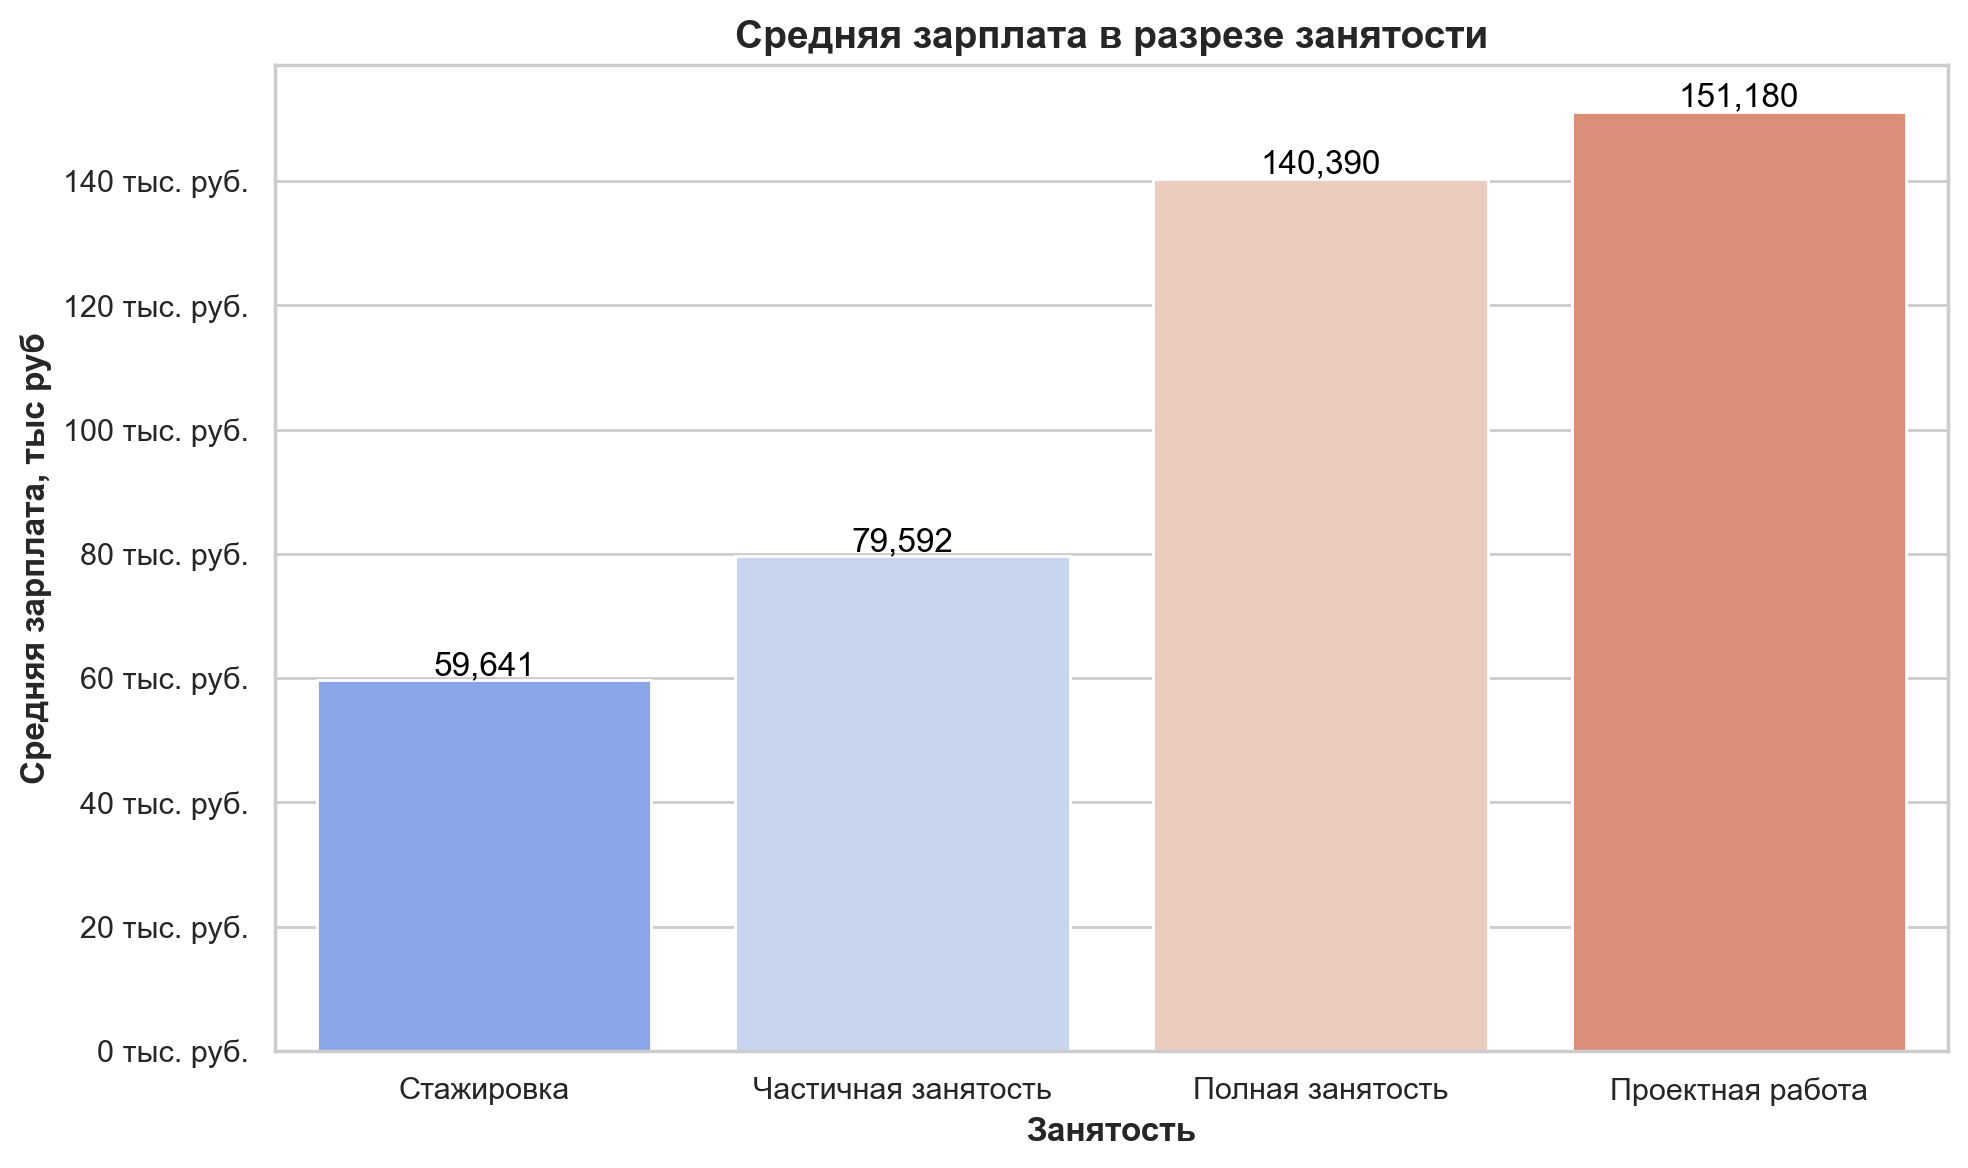

In [1212]:
# Настроим стиль Seaborn
sns.set(style="whitegrid")

# Построение графика
plt.figure(figsize=(10, 6), dpi=200)  # Увеличим размер фигуры и разрешение
ax = sns.barplot(data=employment_salary, x='employment', y='mean_salary', palette='coolwarm')  # Используем палитру 'coolwarm' для столбцов

# Добавление значений над столбцами
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Форматирование оси Y
formatter = FuncFormatter(lambda x, pos: f'{int(x / 1000):,} тыс. руб.')
ax.yaxis.set_major_formatter(formatter)

# Подписи и заголовок
plt.xlabel('Занятость', fontsize=12, weight='bold')
plt.ylabel('Средняя зарплата, тыс руб', fontsize=12, weight='bold')
plt.title('Средняя зарплата в разрезе занятости', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

Анализ столбчатой диаграммы: Средняя зарплата в разрезе занятости

Диаграмма иллюстрирует среднюю зарплату в зависимости от типа занятости. Проверим гипотезу о том, что полная занятость обеспечивает более высокую зарплату по сравнению со стажировками.

Числовые данные:

* Стажировка: 59,641 руб.
* Частичная занятость: 79,592 руб.
* Полная занятость: 140,390 руб.
* Проектная работа: 151,180 руб.

Процентное увеличение:

* Частичная занятость по сравнению со стажировкой: Увеличение на 33.4% 
* Полная занятость по сравнению со стажировкой: Увеличение на 135.3% 
* Проектная работа по сравнению со стажировкой: Увеличение на 153.4% 
* Полная занятость по сравнению с частичной занятостью: Увеличение на 76.3% 
* Проектная работа по сравнению с частичной занятостью: Увеличение на 89.9% 


Вывод:

Гипотеза подтверждается. Средняя зарплата при полной занятости (140,390 руб.) значительно выше, чем при стажировке (59,641 руб.). Разница составляет более чем 135%. Более того, проектная работа также демонстрирует более высокую среднюю зарплату, чем стажировка. Это ожидаемо, поскольку полная занятость и проектная работа, как правило, предполагают большую ответственность и более высокий уровень квалификации по сравнению со стажировкой.


## Гипотеза: Вакансии с фразой “Всему научим” имеют низкую зарплату.

In [1213]:

# Проверяем, есть ли фраза "Всему научим" в key_skills
analysis_df['has_training'] = analysis_df['key_skills'].str.contains('Всему научим', case=False, na=False)

# Преобразуем значения в 'has_training'
analysis_df['has_training'] = analysis_df['has_training'].apply(lambda x: 'Навыки не требуются' if x else 'Навыки требуются')


In [1214]:
has_training_salary = analysis_df.groupby('has_training')['salary_rub'].mean().reset_index(name="mean_salary")
has_training_salary

,has_training,mean_salary
0,Навыки не требуются,132110.810421
1,Навыки требуются,140043.492689


In [1215]:


# Разделяем данные на две группы по значению 'has_training'
group_with_training = analysis_df[analysis_df['has_training'] == 'Навыки не требуются']['salary_rub']
group_without_training = analysis_df[analysis_df['has_training'] == 'Навыки требуются']['salary_rub']

# Проверяем нормальность распределения для каждой группы с помощью теста Шапиро-Уилка
shapiro_with_training = stats.shapiro(group_with_training.dropna())
shapiro_without_training = stats.shapiro(group_without_training.dropna())

# Если p-value меньше 0.05, то распределение не нормально
if shapiro_with_training.pvalue < 0.05 or shapiro_without_training.pvalue < 0.05:
    print('Данные не распределены нормально, используем непараметрический тест Манна-Уитни.')
    # Применяем тест Манна-Уитни для независимых выборок
    u_stat, p_value = stats.mannwhitneyu(group_with_training, group_without_training, alternative='two-sided')
else:
    print('Данные распределены нормально, используем t-тест.')
    # Проводим t-тест для независимых выборок
    t_stat, p_value = stats.ttest_ind(group_with_training, group_without_training, nan_policy='omit')

# Проверяем значимость различий
if p_value < 0.05:
    print(f'Различия в зарплатах статистически значимы (p-value = {p_value})')
else:
    # Округляем p-value до 2 знаков после запятой в выводе
    print(f'Различия в зарплатах не статистически значимы (p-value = {p_value})')

analysis_df = analysis_df.drop(['has_training'], axis=1)

Данные не распределены нормально, используем непараметрический тест Манна-Уитни.
Различия в зарплатах статистически значимы (p-value = 0.031175619681750248)


## Вывод: Различия в зарплатах статистически значимы


## ТОП-10 навыков для каждой профессии IT

In [1216]:
# Фильтруем "Всему научим" и считаем частоту навыков
skills_by_job = (
    analysis_df
    .assign(key_skills=analysis_df['key_skills'].str.split(','))  # Разделяем навыки в списки
    .explode('key_skills')  # Разделяем строки для каждого навыка
    .query("key_skills != 'Всему научим'")  # Исключаем строки с навыком "Всему научим"
    .groupby(['job', 'key_skills'])  # Группируем по профессии и навыку
    .size()  # Считаем количество упоминаний каждого навыка
    .reset_index(name='count')  # Преобразуем в DataFrame
)

# Находим топ-10 навыков для каждой профессии и объединяем их в одну строку
top_skills_by_job = (
    skills_by_job
    .sort_values(['job', 'count'], ascending=[True, False])  # Сортируем
    .groupby('job')  # Группируем по профессии
    .head(10)  # Берем топ-10 навыков
    .groupby('job')['key_skills']  # Группируем по профессии снова
    .apply(lambda x: ', '.join(x))  # Объединяем топовые навыки через запятую
    .reset_index(name='top_skills')  # Преобразуем в DataFrame
)

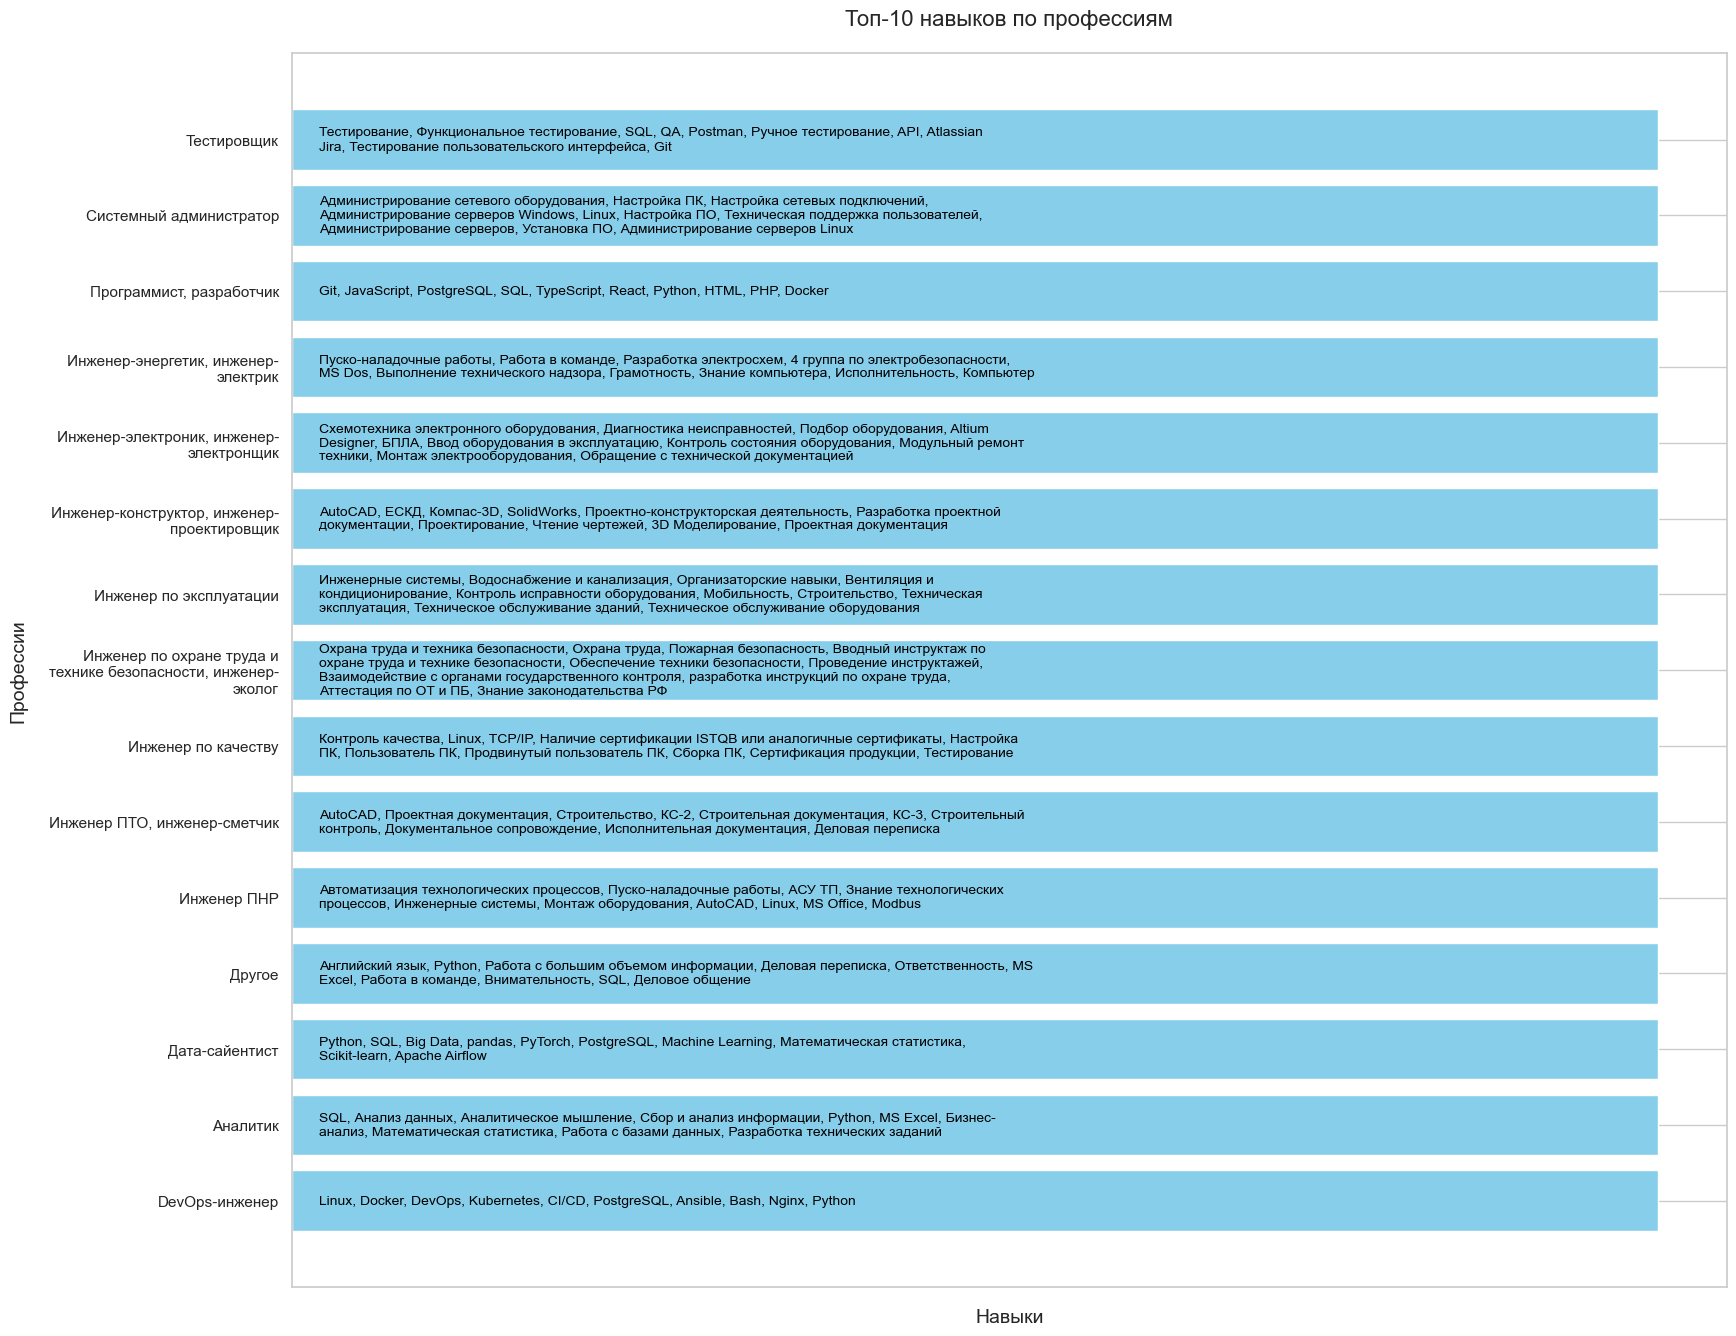

In [1217]:
# Подготовка данных
top_skills_by_job['job'] = top_skills_by_job['job'].str.wrap(30)  # Ограничиваем длину названия профессий
top_skills_by_job['top_skills'] = top_skills_by_job['top_skills'].str.wrap(100)  # Ограничиваем длину строки навыков
top_skills_by_job = top_skills_by_job.sort_values('job', ascending=True)  # Сортируем профессии

# Увеличиваем размер графика
plt.figure(figsize=(18, 14))  # Ещё больше пространства

# Построение горизонтального барчарта
bars = plt.barh(top_skills_by_job['job'], [1] * len(top_skills_by_job), color='skyblue', height=0.8)  # Увеличиваем высоту столбцов

# Добавление аннотаций (навыков)
for bar, skills in zip(bars, top_skills_by_job['top_skills']):
    plt.text(
        0.02,  # Сдвигаем текст немного вправо
        bar.get_y() + bar.get_height() / 2,
        skills,
        ha='left',
        va='center',
        fontsize=10,
        color='black',
    )

# Настройки графика
plt.xlabel('Навыки', fontsize=14, labelpad=15)  # Отдаляем подпись оси X
plt.ylabel('Профессии', fontsize=14, labelpad=15)  # Отдаляем подпись оси Y
plt.title('Топ-10 навыков по профессиям', fontsize=16, pad=20)  # Отдаляем заголовок
plt.xticks([])  # Убираем ось X
plt.tight_layout(pad=2.5)  # Увеличиваем расстояние между элементами

# Показ графика
plt.show()


#  Распределение количества опубликованных вакансий по всем представленным профессиям (данные HeadHunter, Ноябрь 2024)

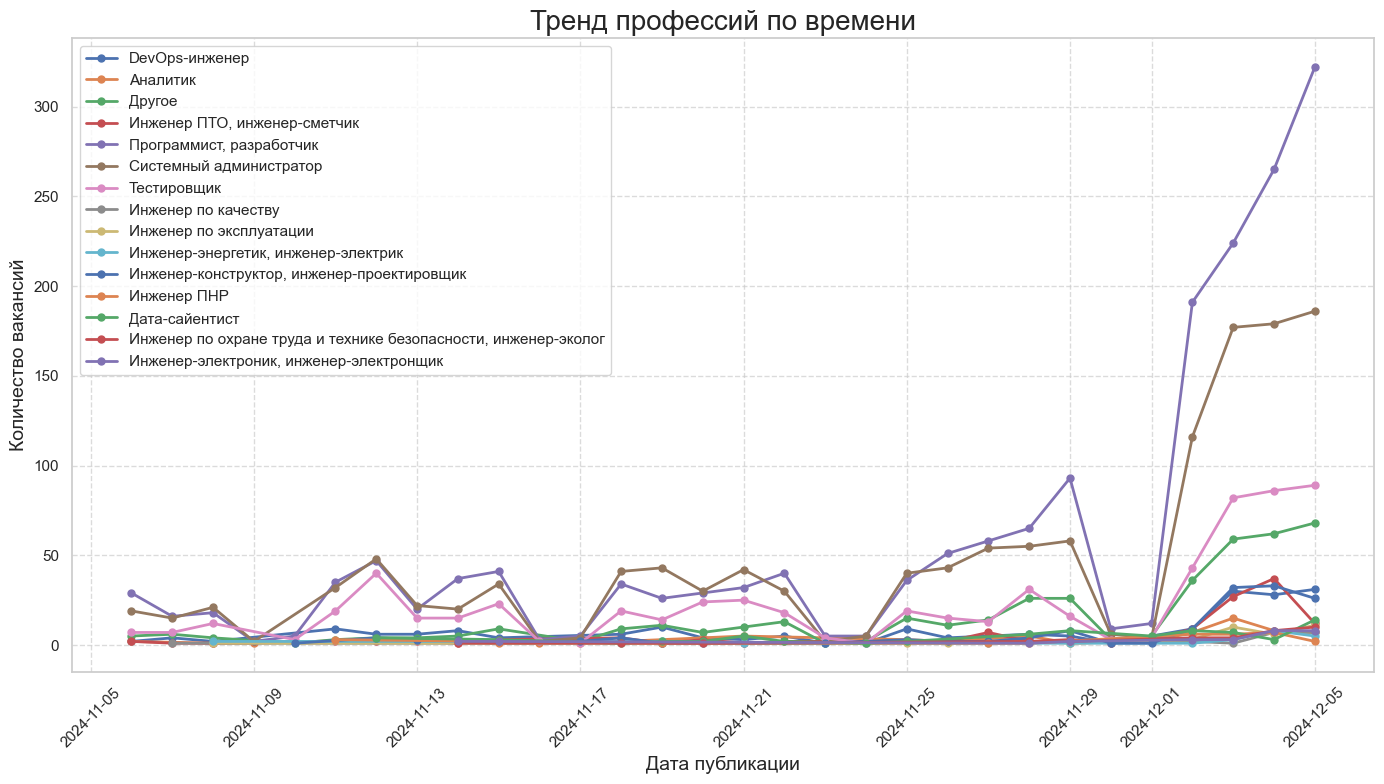

In [1218]:
# Преобразование данных
start_date = pd.to_datetime("2024-11-06")
df_filtered = df[df['published_date'] >= start_date]
df_grouped = df_filtered.groupby([df_filtered['published_date'].dt.date, 'job']).size().reset_index(name='count')

# Подготовка данных для построения графика
jobs = df_grouped['job'].unique()
dates = sorted(df_grouped['published_date'].unique())

# Построение графика
plt.figure(figsize=(14, 8))  # Уменьшаем размер графика

for job in jobs:
    job_data = df_grouped[df_grouped['job'] == job]
    plt.plot(job_data['published_date'], job_data['count'], marker='o', linestyle='-', linewidth=2, markersize=5)

# Настройка графика
plt.title('Тренд профессий по времени', fontsize=20)
plt.xlabel('Дата публикации', fontsize=14)
plt.ylabel('Количество вакансий', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Добавление легенды
plt.legend(jobs, loc='upper left')  # Легенда в левый верхний угол

# Показ графика
plt.show()

Анализ графика показывает, что в выходные дни (период между 10 и 17 ноября, а также между 17 и 24 ноября) количество опубликованных вакансий по всем представленным профессиям значительно снижается. Это заметно по проседанию всех линий графика в указанные периоды. После выходных наблюдается рост числа вакансий. Это указывает на то, что большинство компаний публикуют вакансии в рабочие дни.

# Гипотеза: Количество ключевых навыков в вакансии коррелирует с предлагаемой зарплатой.


In [1219]:
# Добавляем колонку с подсчетом количества ключевых навыков
def count_key_skills(key_skills):
    if key_skills.strip().lower() == "всему научим":  # Проверяем, если значение равно "Всему научим"
        return 0
    return len(key_skills.split(','))  # Иначе считаем количество навыков


In [1220]:

# Создаем новую колонку с использованием .loc
filtered_data.loc[:, 'key_skills_count'] = filtered_data['key_skills'].apply(count_key_skills)

# Вычисление корреляции
correlation, p_value = pearsonr(filtered_data['salary_rub'], filtered_data['key_skills_count'])
print(f"Корреляция: {correlation:.2f}, p-value: {p_value:.4f}")

# Проверяем наличие и силу корреляции
if abs(correlation) < 0.3:
    strength = "слабая"
elif abs(correlation) < 0.7:
    strength = "умеренная"
else:
    strength = "сильная"

if correlation > 0:
    direction = "положительная"
elif correlation < 0:
    direction = "отрицательная"
else:
    direction = "отсутствует"

# Вывод результата
if p_value < 0.05:  # Проверяем статистическую значимость
    print(f"Корреляция значима: {strength}, {direction} (r = {correlation:.2f}, p-value = {p_value:.4f})")
else:
    print(f"Корреляция статистически незначима (r = {correlation:.2f}, p-value = {p_value:.4f})")

Корреляция: 0.05, p-value: 0.0002
Корреляция значима: слабая, положительная (r = 0.05, p-value = 0.0002)


/var/folders/dk/n71lg2t15112j9nnvkz6cznm0000gn/T/ipykernel_30836/2434780788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'key_skills_count'] = filtered_data['key_skills'].apply(count_key_skills)


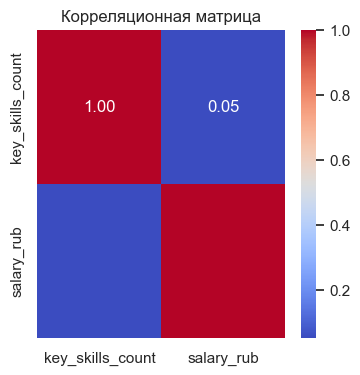

In [1221]:
correlation_matrix = filtered_data[['key_skills_count', 'salary_rub']].corr()

# Визуализация тепловой карты
plt.figure(figsize=(4, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Корреляционная матрица')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


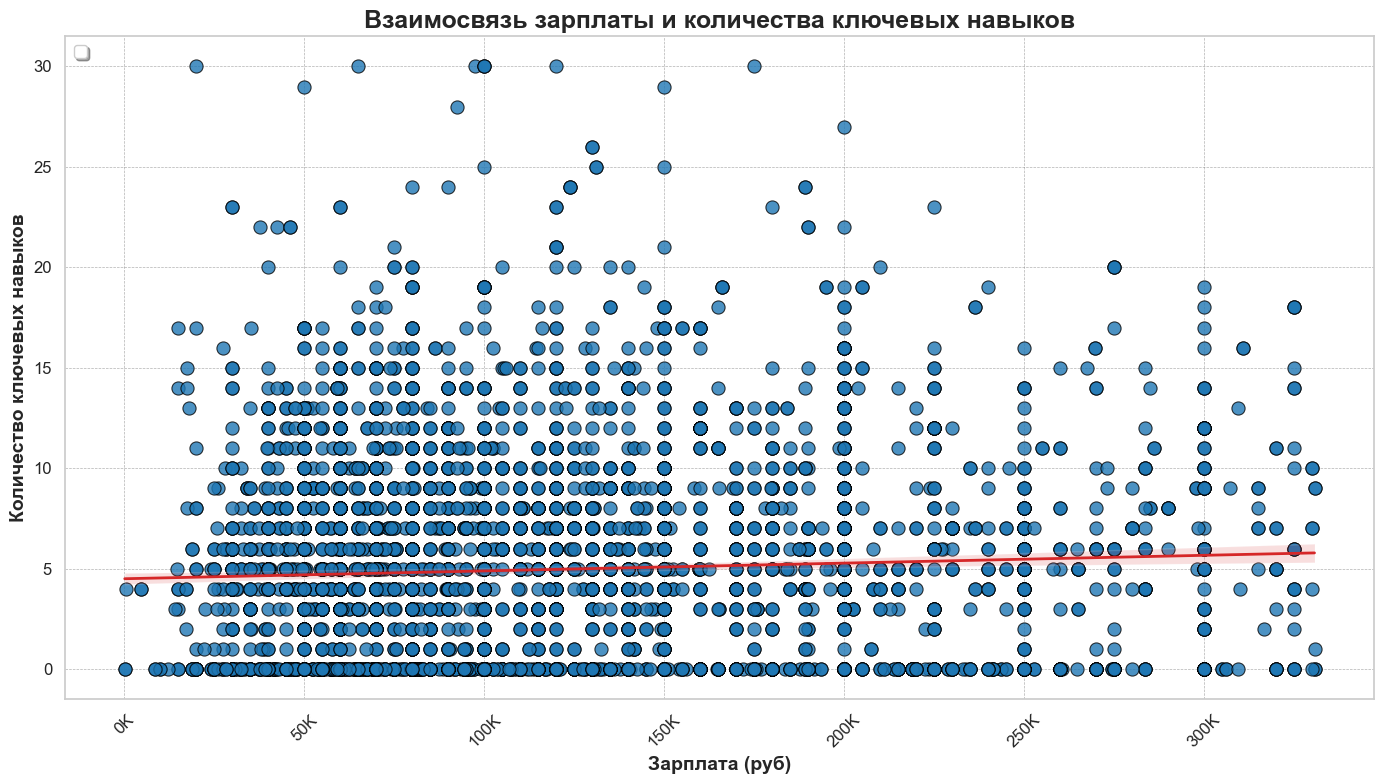

In [1222]:
# Данные (предположим, что `filtered_data` уже определен)
correlation = filtered_data['salary_rub'].corr(filtered_data['key_skills_count'])

# Устанавливаем стиль для графика
sns.set(style="whitegrid")

# Увеличиваем размер фигуры для лучшего отображения
plt.figure(figsize=(14, 8))

# Создаем график рассеяния
scatter = sns.scatterplot(
    x='salary_rub',
    y='key_skills_count',
    data=filtered_data,
    alpha=0.8,
    color='#1f77b4',  # Изменяем цвет точек
    edgecolor='black',  # Черная окантовка для точек
    s=90  # Размер точек
)

# Добавляем линию тренда
regplot = sns.regplot(
    x='salary_rub',
    y='key_skills_count',
    data=filtered_data,
    scatter=False,
    color='#d62728',  # Цвет линии тренда
    line_kws={'label': f'Корреляция: {correlation:.2f}', 'lw': 2}  # Линия тренда с меткой
)

# Оформляем график
plt.title('Взаимосвязь зарплаты и количества ключевых навыков', fontsize=18, weight='bold')
plt.xlabel('Зарплата (руб)', fontsize=14, weight='bold')
plt.ylabel('Количество ключевых навыков', fontsize=14, weight='bold')

# Устанавливаем форматирование для чисел на оси X
plt.xticks(fontsize=12, rotation=45)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))

plt.yticks(fontsize=12)

# Добавляем легенду
plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)

# Добавляем сетку с более мягкой прозрачностью
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)

# Упрощаем отображение
plt.tight_layout()

# Отображаем график
plt.show()

График показывает слабую положительную корреляцию между количеством ключевых навыков, указанных в вакансии, и предлагаемой зарплатой. Линия регрессии имеет небольшой положительный наклон, но значительная часть точек разбросана, что свидетельствует о невысокой силе связи.

Вероятно, такой график наблюдается потому, что, хотя большая зарплата часто требует более широкого набора навыков, это не является единственным определяющим фактором. Другие факторы, такие как опыт работы, специализация, местоположение компании и сам уровень позиции, оказывают гораздо большее влияние на уровень заработной платы, чем просто количество перечисленных навыков. Многие вакансии с высокой зарплатой могут требовать глубокого экспертного знания в узкой области, а не большого количества разнообразных навыков. Наоборот, вакансии с большим количеством навыков могут предлагать более низкую зарплату, если эти навыки являются базовыми или легкодоступными.

# Гипотеза: Уровень заработной платы коррелирует с количеством и уровнем востребованных навыков.


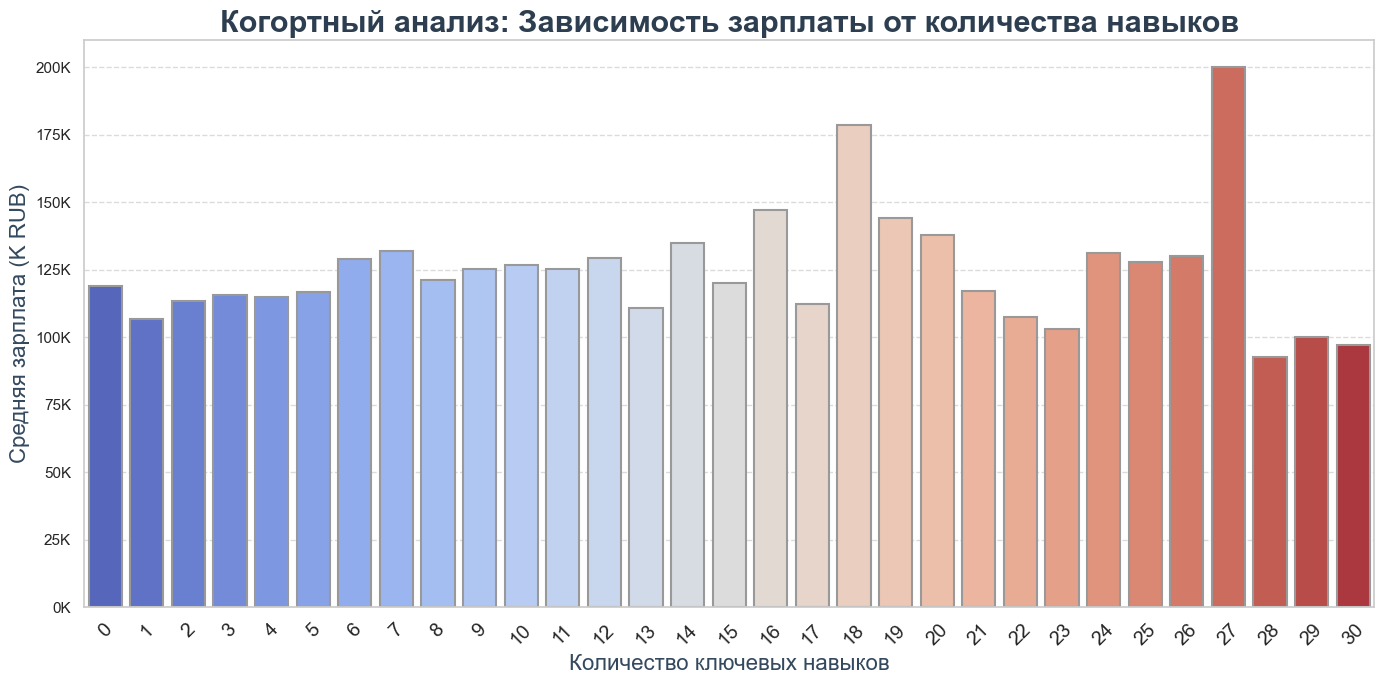

In [1223]:
cohorts = filtered_data.groupby('key_skills_count')['salary_rub'].mean()

# Визуализация
plt.figure(figsize=(14, 7))
sns.barplot(x=cohorts.index, y=cohorts.values, palette="coolwarm", edgecolor=".6", linewidth=1.5)
plt.title("Когортный анализ: Зависимость зарплаты от количества навыков", fontsize=22, weight='bold', color='#2c3e50')
plt.xlabel("Количество ключевых навыков", fontsize=16, weight='medium', color='#34495e')
plt.ylabel("Средняя зарплата (K RUB)", fontsize=16, weight='medium', color='#34495e')
plt.xticks(rotation=45, fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7, color='.8')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))
plt.tight_layout()
plt.show()

График показывает когорный анализ зависимости средней зарплаты от количества ключевых навыков в вакансиях. Видим немонотонную зависимость: зарплата растет с увеличением количества навыков до определенного пика (около 19 навыков), после чего начинает снижаться.

Скорее всего, такой график объясняется следующим:

• До пика: Увеличение количества навыков отражает рост сложности и ответственности вакансии, что и приводит к увеличению зарплаты. Это типично для senior-позиций, требующих широкого спектра знаний и опыта.

• После пика: Снижение средней зарплаты при большем количестве навыков может быть обусловлено несколькими факторами:
  * Менее специализированные роли: Вакансии с очень большим количеством навыков могут представлять собой роли с более широким, но менее глубоким набором компетенций, которые оплачиваются ниже, чем узкоспециализированные, высококвалифицированные позиции.
  * Дробление задач: Возможно, большое число навыков отражает дробление сложной работы на несколько более простых, менее оплачиваемых задач.
  * Несоответствие навыков требованиям: Перечисление большого количества навыков может говорить о нечётком понимании работодателем необходимых компетенций, что может приводить к занижению зарплаты для компенсации неопределенности.
  * Нехватка данных: Возможно, при большом числе навыков просто меньше данных, что приводит к неточности оценки средней зарплаты.

В целом, график демонстрирует, что простая линейная корреляция между количеством навыков и зарплатой отсутствует, а оптимальное число навыков с точки зрения средней заработной платы находится в районе 19. Необходимо дальнейшее исследование, чтобы подтвердить эти предположения.



/var/folders/dk/n71lg2t15112j9nnvkz6cznm0000gn/T/ipykernel_30836/3499994202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['skills_group'] = pd.cut(filtered_data['key_skills_count'], bins=bins, labels=labels, right=False)


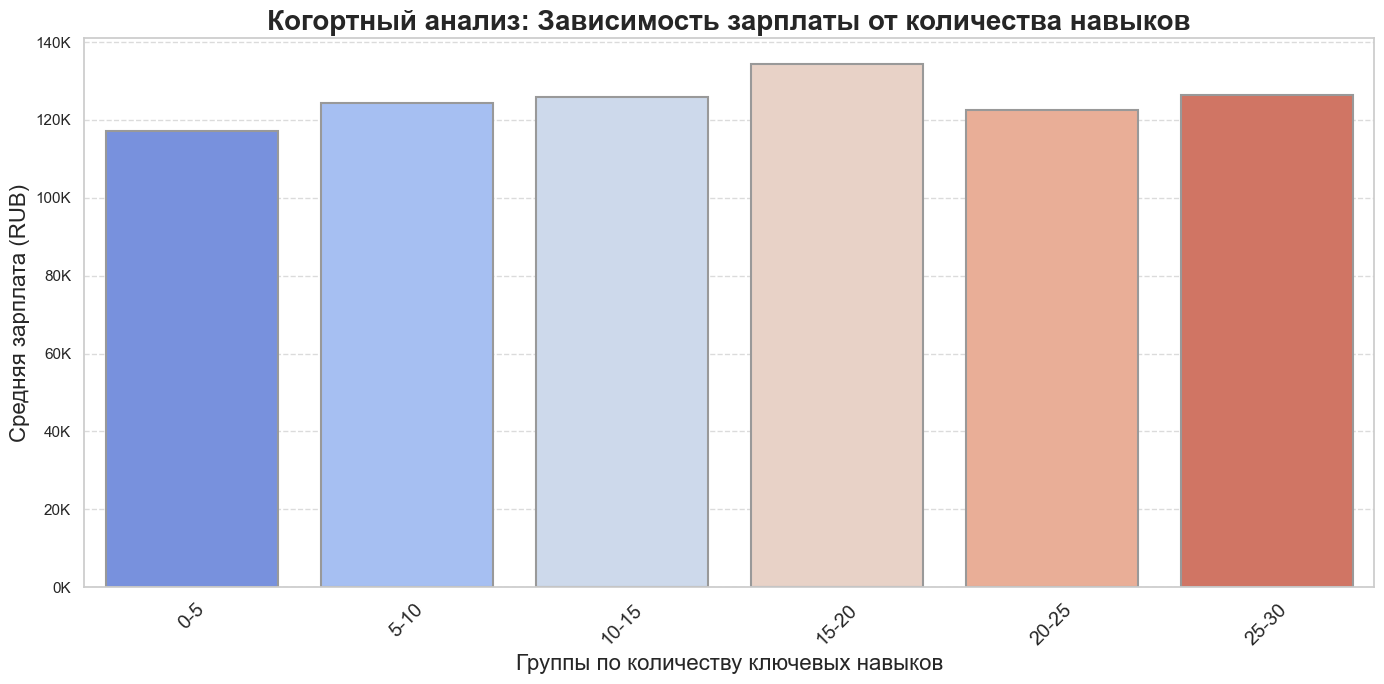

In [1224]:
bins = np.arange(0, 35, 5)  # Интервалы: 0-5, 5-10, ..., 25-30
labels = [f"{i}-{i+5}" for i in bins[:-1]]
filtered_data['skills_group'] = pd.cut(filtered_data['key_skills_count'], bins=bins, labels=labels, right=False)

# Группируем данные по интервалам навыков и рассчитываем среднюю зарплату
cohorts = filtered_data.groupby('skills_group')['salary_rub'].mean()

# Визуализация
plt.figure(figsize=(14, 7))
sns.barplot(x=cohorts.index, y=cohorts.values, palette="coolwarm", edgecolor=".6", linewidth=1.5)
plt.title("Когортный анализ: Зависимость зарплаты от количества навыков", fontsize=20, weight='bold')
plt.xlabel("Группы по количеству ключевых навыков", fontsize=16, weight='medium')
plt.ylabel("Средняя зарплата (RUB)", fontsize=16, weight='medium')
plt.xticks(rotation=45, fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7, color='.8')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:.0f}K'))
plt.tight_layout()
plt.show()

Этот столбчатый график показывает когорный анализ зависимости средней зарплаты от диапазонов количества ключевых навыков в вакансиях. Видна явная положительная корреляция: средняя зарплата постепенно увеличивается с ростом количества навыков.

Такая тенденция вполне ожидаема и логична: с увеличением числа требуемых навыков растет сложность работы, требуются более глубокие знания и опыт, что естественным образом приводит к повышению уровня оплаты труда. График демонстрирует постепенное, монотонное возрастание средней зарплаты в зависимости от количества требуемых навыков, в отличие от предыдущего графика, где наблюдался пик и последующее снижение. Это может указывать на то, что в данном случае выборка данных или методика группировки по диапазонам количества навыков более точно отображают реальную зависимость на рынке труда.


In [1229]:
total_model = analysis_df[['area', 'schedule', 'experience', 'employment', 'key_skills', 'job', 'salary_rub']]

In [1230]:
total_model.to_csv('job_dataset')